In [1]:
# Set Keras 3 backend to PyTorch and enable CUDA
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
keras.config.set_backend("torch")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Keras backend:", keras.backend.backend())
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Selected device:", device)

Keras backend: torch
PyTorch CUDA available: True
Selected device: cuda


In [2]:

import sys
sys.path.append(os.path.abspath("../src"))

from data.loader import load_and_clean_raw_dataset



# --- Global config
LOOKBACK = 20
BATCH_SIZE = 32
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = LOOKBACK * (11 * 10 + 1 + 32)

TARGET_DATE = "2025-05-21"
TARGET_STRIKE = 1.0
TARGET_TAU = 1.0

USE_PREPROCESSED_INPUTS = False


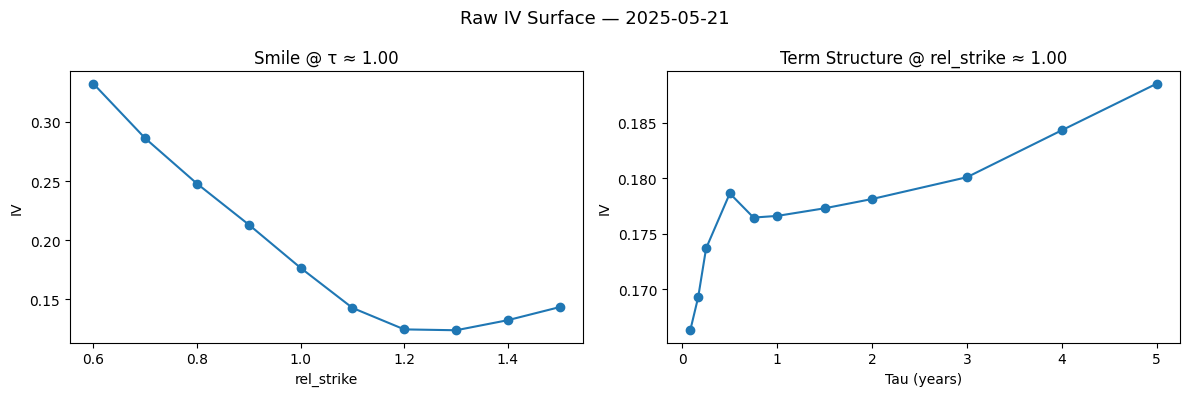

In [3]:

from data.loader import load_and_clean_raw_dataset

df = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")


from utils.plotting import plot_raw_iv_slice

plot_raw_iv_slice(df, target_date=TARGET_DATE, target_strike=TARGET_STRIKE, target_tau=TARGET_TAU,)



In [4]:
from data.dataset_builder import build_full_surface_feature_df

# Load enriched surface + features
df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")

# Identify IV and feature columns
iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]
df_all = df_all.dropna(subset=feat_cols)

print("Final DataFrame shape:", df_all.shape)
print("Surface columns:", len(iv_cols), "| Feature columns:", len(feat_cols))
print("IV column sample:", iv_cols[:5])
print("Feature column sample:", feat_cols[:5])
print(df_all.columns)


Final DataFrame shape: (1265, 136)
Surface columns: 110 | Feature columns: 26
IV column sample: ['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00']
Feature column sample: ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20']
Index(['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00',
       'IV_1m_1.10', 'IV_1m_1.20', 'IV_1m_1.30', 'IV_1m_1.40', 'IV_1m_1.50',
       ...
       'slope_10_30', 'smile_skew', 'smile_convexity', 'ts_level', 'ts_slope',
       'ts_curvature', 'ts_weighted', 'ts_short_avg', 'ts_long_avg',
       'ts_split_slope'],
      dtype='object', length=136)


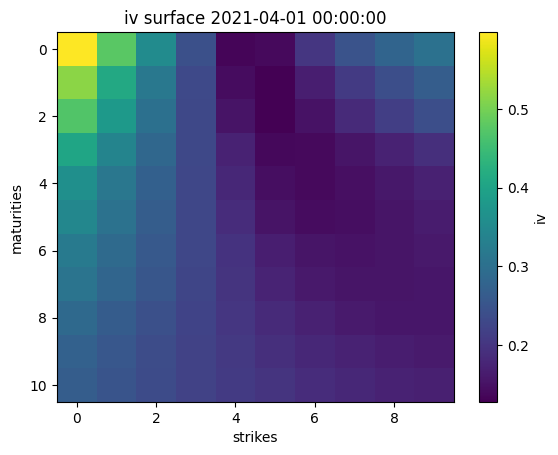


surface 2021-04-01 00:00:00


strike       0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
maturity                                                                   
18m       0.5974  0.4770  0.3541  0.2425  0.1337  0.1408  0.2027  0.2483   
1m        0.5164  0.4122  0.3165  0.2313  0.1441  0.1293  0.1672  0.2085   
1y        0.4700  0.3810  0.3014  0.2302  0.1537  0.1280  0.1519  0.1847   
2m        0.4032  0.3399  0.2843  0.2299  0.1723  0.1376  0.1396  0.1539   
2y        0.3622  0.3142  0.2711  0.2273  0.1800  0.1447  0.1392  0.1464   
3m        0.3454  0.3047  0.2667  0.2279  0.1867  0.1528  0.1429  0.1460   
3y        0.3220  0.2904  0.2600  0.2288  0.1963  0.1677  0.1542  0.1518   
4y        0.3082  0.2803  0.2536  0.2267  0.1993  0.1748  0.1601  0.1544   
5y        0.2876  0.2646  0.2432  0.2227  0.2024  0.1841  0.1704  0.1617   
6m        0.2734  0.2546  0.2374  0.2213  0.2060  0.1922  0.1808  0.1722   
9m        0.2666  0.2498  0.2344  0.2207  0.2085  0.1978  0.1883  0.1801   

strike       1.4     1.5  
maturity                  
18m       0.2800  0.3032  
1m        0.2412  0.2664  
1y        0.2154  0.2410  
2m        0.1722  0.1918  
2y        0.1575  0.1704  
3m        0.1539  0.1634  
3y        0.1550  0.1606  
4y        0.1542  0.1570  
5y        0.1572  0.1559  
6m        0.1663  0.1628  
9m        0.1735  0.1688

In [5]:
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

# select random date
ix = np.random.randint(len(df_all))
date = df_all.index[ix]

# parse shape from columns
maturities = sorted(set(re.search(r"IV_(.*?)_", c).group(1) for c in iv_cols))
strikes = sorted(set(float(re.search(r"_(\d\.\d+)", c).group(1)) for c in iv_cols))

# extract surface
surface_values = df_all.iloc[ix][iv_cols].values.reshape(len(maturities), len(strikes))

# plot
plt.imshow(surface_values, cmap="viridis", aspect="auto")
plt.title(f"iv surface {date}")
plt.xlabel("strikes")
plt.ylabel("maturities")
plt.colorbar(label="iv")
plt.show()

# surface table
surface_df = pd.DataFrame(surface_values, index=maturities, columns=strikes)
surface_df.index.name = "maturity"
surface_df.columns.name = "strike"

print(f"\nsurface {date}")
display(surface_df.round(4))

In [6]:
from data.tensor_builder import prepare_surface_and_feature_tensors
from keras import ops

# Build tensors from cleaned DataFrames
tensors, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
    df_all=df_all,
    df_raw=df,  # original raw dataframe is named df
    feat_cols=feat_cols,
    monthly_interpolation=False
)

# Print tensor shapes
print("Tensors built:")
for k, v in tensors.items():
    try:
        print(f"  • {k:20s}: {ops.shape(v)}")
    except Exception:
        print(f"  • {k:20s}: {type(v)}")

print("\nFeature tensor:", ops.convert_to_numpy(X_feat_tensor).shape)

print("Feature DataFrame:", df_feat.shape)

print("Feature columns:", df_feat.columns)

Tensors built:
  • date_tensor         : (1258,)
  • spot_tensor         : (1258,)
  • curve_tensor        : (1258, 32)
  • surface_tensor      : (1258, 11, 10, 6)
  • ssvi_tensor         : (1258, 11, 10, 3)
  • heston_tensor       : (1258, 11, 5)
  • strike_tensor       : (10,)
  • abs_strike_tensor   : (1258, 10)
  • dates               : <class 'list'>
  • maturities          : <class 'list'>
  • taus                : <class 'list'>
  • rel_strikes         : <class 'list'>
  • date_index          : <class 'dict'>
  • maturity_to_tau     : <class 'dict'>
  • iv_diff_tensor      : (1258, 11, 10, 7)

Feature tensor: (1258, 136)
Feature DataFrame: (1258, 26)
Feature columns: Index(['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d',
       'realized_vol_5d_ma20', 'realized_vol_5d_z20', 'rate_0.25y',
       'rate_0.5y', 'rate_1y', 'rate_2y', 'rate_3y', 'rate_4y', 'rate_5y',
       'rate_10y', 'rate_30y', 'slope_5_10', 'slope_10_30', 'smile_skew',
       'smile_convexity

---
---

#PCA-VAR PIPELINE

pca-var rmse: 0.0166


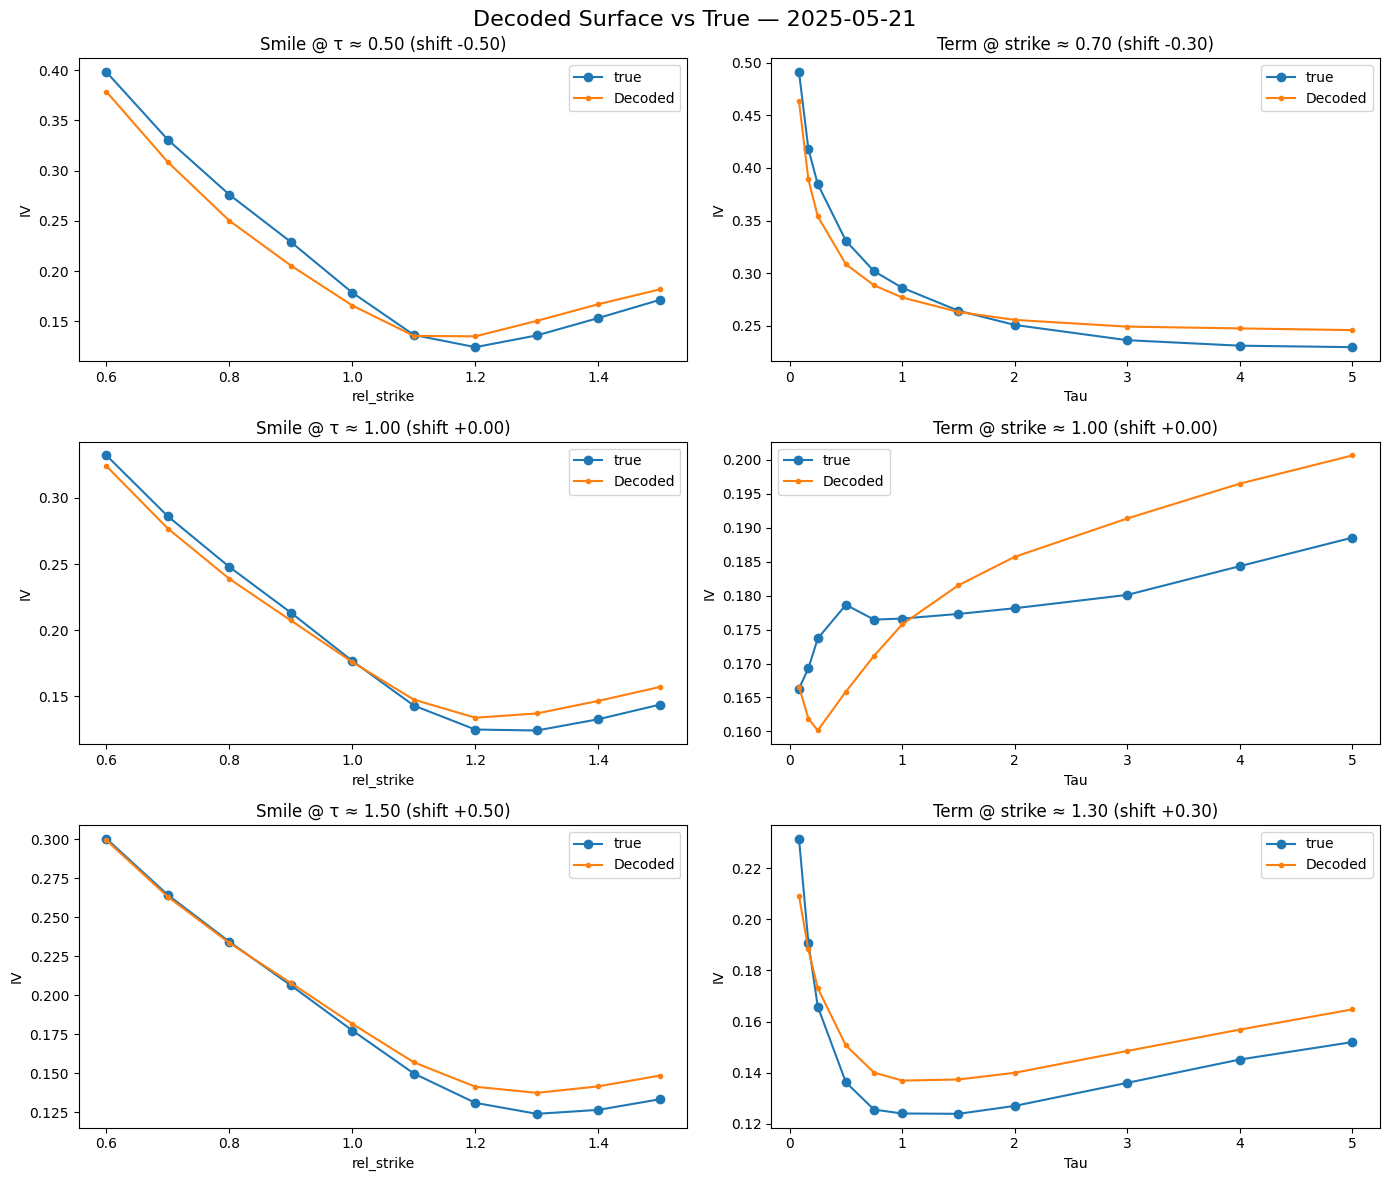

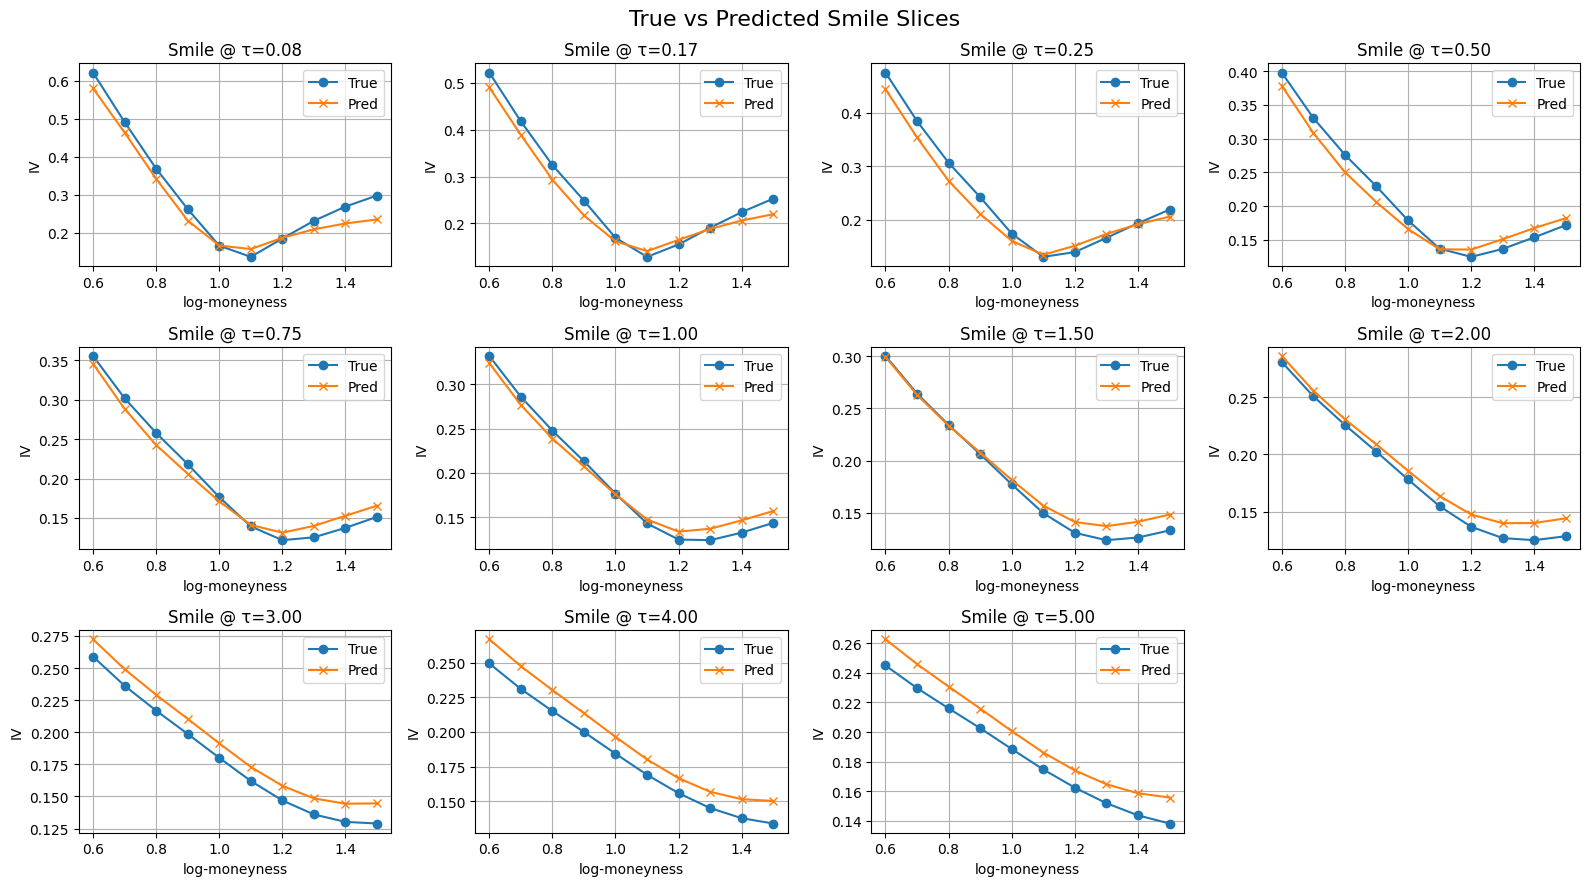

In [7]:
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from sklearn.metrics import root_mean_squared_error

# extract surface tensor and flatten
iv_surface = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]  # shape (T, M, K)
T, M, K = iv_surface.shape
X_surface_flat = iv_surface.reshape(T, M * K).astype(np.float64)

# align with features
feature_index = df_feat.index.intersection(df_all.index)
X_df = df_all.loc[feature_index, iv_cols]
F = df_feat.loc[feature_index]
X_grid = X_df.values.astype(np.float64)
F_aligned = F.values.astype(np.float64)

# demean surfaces
X_mean = X_grid.mean(axis=1, keepdims=True)
X_demeaned = X_grid - X_mean

# fit pca
pca_model = PCA(n_components=LATENT_DIM)
Z_all_pca = pca_model.fit_transform(X_demeaned)
Z_aug_pca = np.concatenate([Z_all_pca, F_aligned], axis=1)

# train test split
T_total = len(Z_aug_pca)
T_train = int(0.7 * T_total)
Z_train = Z_aug_pca[:T_train]
Z_test = Z_aug_pca[T_train:]
Z_train_pure = Z_all_pca[:T_train]

# var on augmented z
var_model = VAR(Z_train)
var_result = var_model.fit(maxlags=5)
Z_forecast_pca = var_result.forecast(Z_train[-var_result.k_ar:], steps=len(Z_test))
Z_forecast_pure = Z_forecast_pca[:, :LATENT_DIM]

# reconstruct surfaces
X_recon_demeaned = pca_model.inverse_transform(Z_forecast_pure)
X_mean_forecast = X_mean[T_train:T_train + len(X_recon_demeaned)]
X_pred_pca = X_recon_demeaned + X_mean_forecast
X_true_pca = X_grid[T_train:T_train + len(X_pred_pca)]

# calc rmse
rmse_pca = root_mean_squared_error(X_true_pca, X_pred_pca)
print(f"pca-var rmse: {rmse_pca:.4f}")

# reshape for plotting
X_true_pca = X_true_pca.reshape(-1, M, K)
X_pred_pca = X_pred_pca.reshape(-1, M, K)

from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison

# last surface for plots
true_surface_t = X_true_pca[-1]
recon_surface_t = X_pred_pca[-1]

plot_iv_slices_shifts(
    true_surface=true_surface_t,
    decoded_surface=recon_surface_t,
    taus=tensors["taus"],
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    decoded_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
)

plot_smile_slices_comparison(
    true_surface=true_surface_t,
    pred_surface=recon_surface_t,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=tensors["taus"],
)

---
---

# DATASET CREATION


---
---

In [9]:
from keras.models import load_model
from models.lstm import EncodedLatentSequence
from models.gru import GRUForecasterAugmented
from keras import ops
import numpy as np
from data.dataset import FeatureToLatentSequenceDataset
import importlib
import models.fw_pca
importlib.reload(models.fw_pca)
from models.fw_pca import FeatureWeightedPCA, FWPCAEncoderWrapper, FWPCADecoderWrapper

# load fwpca encoder
iv_surface = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]
T, M, K = iv_surface.shape
X_flat = iv_surface.reshape(T, M * K)
F = ops.convert_to_numpy(X_feat_tensor)
X_combined = np.hstack([X_flat, F])

valid_mask = np.all(np.isfinite(X_combined), axis=1)
X_valid_flat = X_flat[valid_mask]
F_valid = F[valid_mask]

fwpca = FeatureWeightedPCA(n_components=12)
fwpca.fit(ops.convert_to_tensor(X_valid_flat), ops.convert_to_tensor(F_valid))
encoder = FWPCAEncoderWrapper(fwpca, ops.convert_to_tensor(F_valid), M, K)
decoder = FWPCADecoderWrapper(encoder)  # takes the encoder and inverse transforms

# full dataset for gru input
full_dataset = FeatureToLatentSequenceDataset(
    surface_tensor=tensors["surface_tensor"],
    feature_tensor=X_feat_tensor,
    lookback=LOOKBACK,
    batch_size=BATCH_SIZE,
    global_indices=np.arange(T)
)
gru_input_gen = EncodedLatentSequence(full_dataset, encoder)

# load gru model
gru_model = load_model(
    "saved_models/gru/gru_model_fwpca.keras",
    custom_objects={"GRUForecasterAugmented": GRUForecasterAugmented, 
                    "FeatureWeightedPCA": FeatureWeightedPCA,  # important !
                    "FWPCAEncoderWrapper": FWPCAEncoderWrapper}
)



# forecast z(t+1)
Z_forecast_fwpca = gru_model.predict(gru_input_gen, verbose=0)

# optional demeaning
apply_demeaning = False
z_mean = ops.convert_to_numpy(ops.mean(Z_forecast_fwpca, axis=0, keepdims=True)) if apply_demeaning else 0.0
Z_forecast_demeaned = Z_forecast_fwpca - z_mean if apply_demeaning else Z_forecast_fwpca

# align surface slices
X_surface_all = ops.convert_to_numpy(tensors["surface_tensor"][..., -1].reshape(T, -1))
idx_eval = ops.convert_to_numpy(full_dataset.global_indices)[-len(Z_forecast_demeaned):]

# align dims
n_forecasts = Z_forecast_demeaned.shape[0]

Z_decoder = Z_forecast_demeaned
Y_decoder = X_surface_all[-n_forecasts:]
F_aligned = ops.convert_to_numpy(X_feat_tensor[-n_forecasts:])

print("training data debug:")
print(f"n_forecasts: {n_forecasts}")
print(f"Z_decoder shape: {Z_decoder.shape}")
print(f"Y_decoder shape: {Y_decoder.shape}")  
print(f"F_aligned shape: {F_aligned.shape}")

print(f"Z_decoder[0] sample: {Z_decoder[0][:5]}")
print(f"F_aligned[0] sample: {F_aligned[0][:5]}")
print(f"Y_decoder[0] sample: {Y_decoder[0][:5]}")

# decode surfaces using fwpca
Y_hat = encoder.inverse_transform(Z_decoder)

print(f"first prediction sample: {Y_hat[0].flatten()[:5]}")

# sanity checks
assert Z_decoder.shape[0] == Y_decoder.shape[0], "forecast-surface alignment mismatch"
assert Z_decoder.shape[0] == F_aligned.shape[0], "forecast-feature alignment mismatch"

training data debug:
n_forecasts: 1216
Z_decoder shape: (1216, 12)
Y_decoder shape: (1216, 110)
F_aligned shape: (1216, 136)
Z_decoder[0] sample: [ 0.4937629   0.17786802  0.03961948 -0.02726837  0.15255243]
F_aligned[0] sample: [ 0.00059401  0.00421119 -0.18319322  0.00906852  0.01874819]
Y_decoder[0] sample: [0.70493627 0.5732201  0.46057191 0.36976174 0.26840553]
first prediction sample: [0.6722888  0.5627752  0.47132412 0.37634867 0.24324852]


In [10]:
import importlib
import data.dataset
importlib.reload(data.dataset)

from data.tensor_builder import split_time_series_indices
from keras import ops
import pandas as pd

T = tensors["surface_tensor"].shape[0]
train_idx, val_idx, test_idx = split_time_series_indices(T)

target_date = pd.Timestamp("2025-05-21")
idx = np.where(tensors["date_tensor"] == target_date)[0][0]

print("[DATE CHECK]")
print("Target global index:", idx)
print("Train:", train_idx[[0, -1]])
print("Val:", val_idx[[0, -1]])
print("Test:", test_idx[[0, -1]])
print("In test?", idx in test_idx)


[DATE CHECK]
Target global index: 1257
Train: [  0 879]
Val: [ 880 1068]
Test: [1069 1257]
In test? True


X_pred_raw shape: (1216, 110)

debug plot_iv_slices_shifts atm indexing:
target_strike: 1.0
strike_val: 1.0
k_idx: 4
actual strike: 1.0
atm term from plot: [0.16631064 0.16929014 0.17368743 0.17863896 0.17646223 0.176611
 0.17729895 0.17813316 0.18009801 0.18432647 0.18852447]
expected atm (idx 4): [0.16631064 0.16929014 0.17368743 0.17863896 0.17646223 0.176611
 0.17729895 0.17813316 0.18009801 0.18432647 0.18852447]
equal? True
FW-PCA-GRU Decoded Surface RMSE_σ: 0.0172
RMSE by maturity (mean ± std): 0.0176 ± 0.0102
RMSE by strike    (mean ± std): 0.0199 ± 0.0043


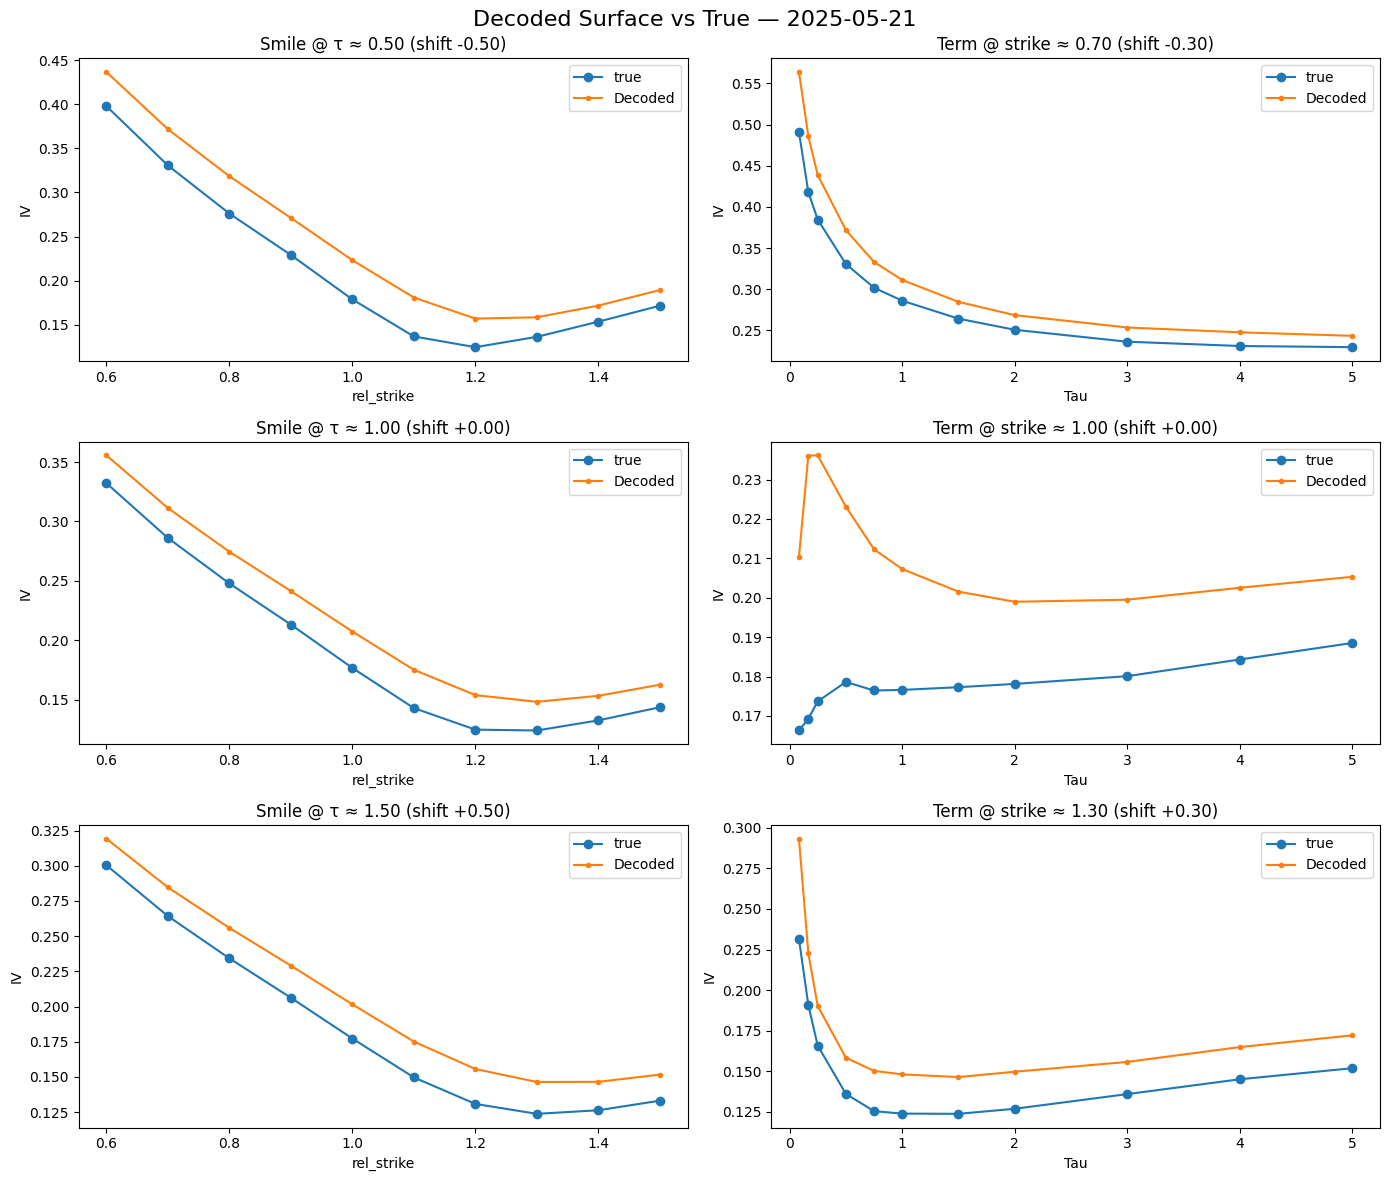

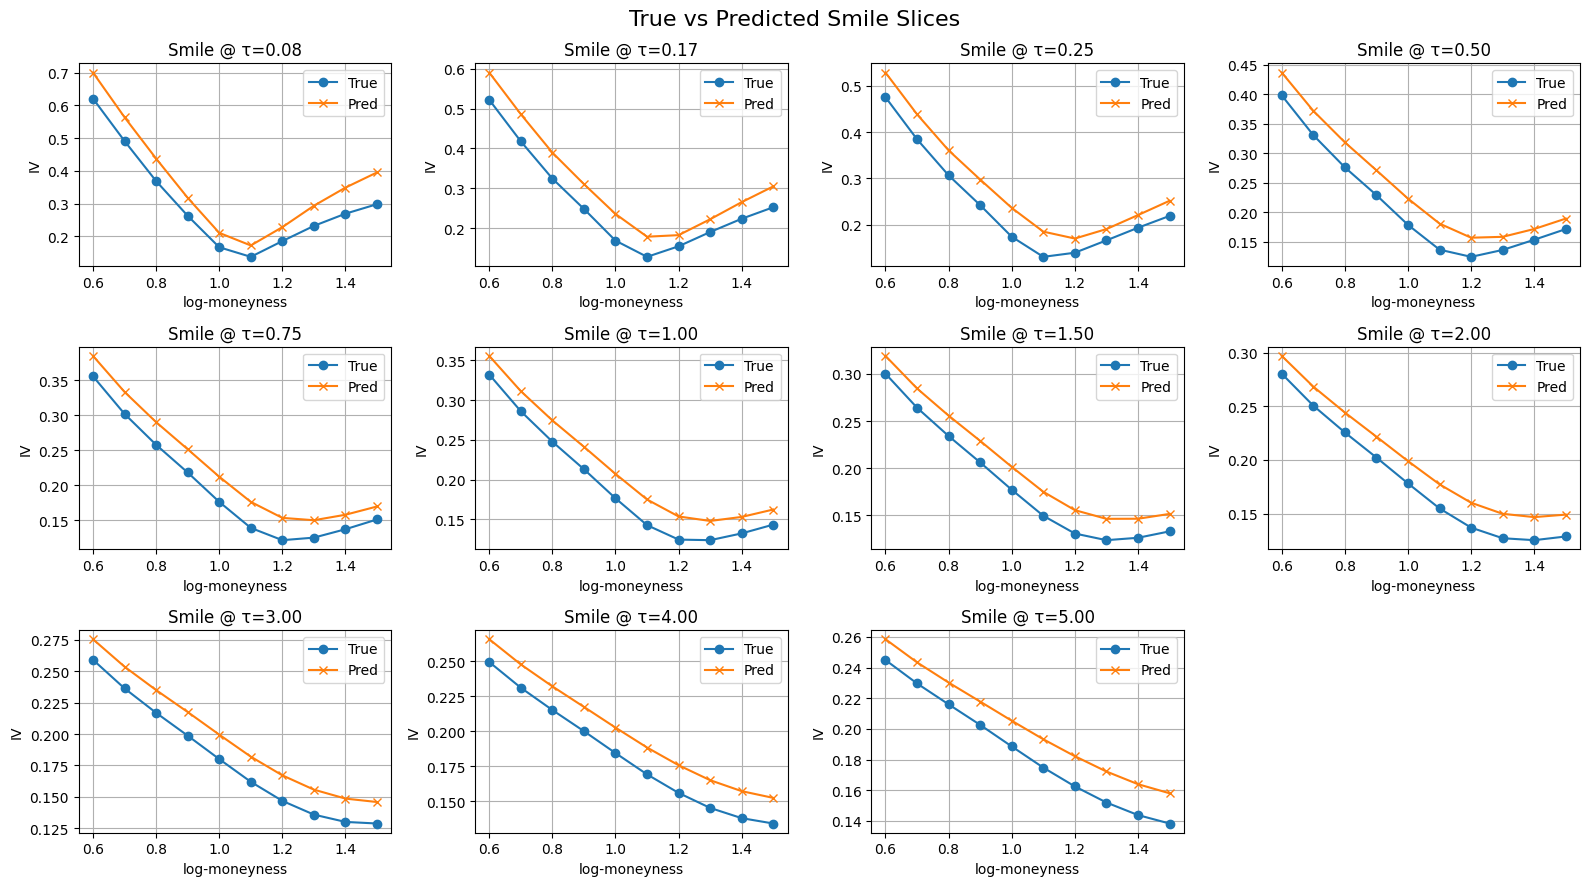

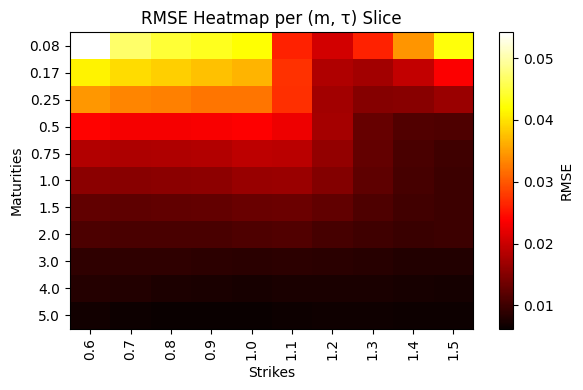

In [11]:
import importlib
import utils.eval
importlib.reload(utils.eval)
import utils.plotting
importlib.reload(utils.plotting)

from utils.eval import evaluate_decoder_output

# predict surfaces using fwpca inverse transform
X_pred_raw = encoder.inverse_transform(Z_decoder)  # (B, M*K)
print("X_pred_raw shape:", X_pred_raw.shape)

# debug atm indexing
print("\ndebug plot_iv_slices_shifts atm indexing:")
target_strike = TARGET_STRIKE  # should be 1.0
k_shift = 0.0  # middle term structure plot
strike_val = target_strike + k_shift
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
k_idx = np.argmin(np.abs(rel_strikes - strike_val))

print(f"target_strike: {target_strike}")
print(f"strike_val: {strike_val}")
print(f"k_idx: {k_idx}")
print(f"actual strike: {rel_strikes[k_idx]}")

# compare with ground truth
Y_decoder_reshaped = Y_decoder.reshape(-1, M, K)
print(f"atm term from plot: {Y_decoder_reshaped[-1, :, k_idx]}")
print(f"expected atm (idx 4): {Y_decoder_reshaped[-1, :, 4]}")
print(f"equal? {np.array_equal(Y_decoder_reshaped[-1, :, k_idx], Y_decoder_reshaped[-1, :, 4])}")

# evaluate against y_decoder
evaluate_decoder_output(
    decoder=encoder,  # fwpca encoder wrapper
    Z_forecast=Z_decoder,
    X_grid=Y_decoder,
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_raw,
    title="FW-PCA-GRU Decoded Surface"
)

---
---

# POINTWISE DECODER 

---
---

In [12]:
import models.decoder
import importlib
importlib.reload(models.decoder)

from models.decoder import PiecewiseSurfaceDecoder
from keras.optimizers import Adam

print("training data shapes:")
print(f"Z_decoder shape: {Z_decoder.shape}")
print(f"F_aligned shape: {F_aligned.shape}")
print(f"Y_decoder shape: {Y_decoder.shape}")
print(f"LATENT_DIM: {LATENT_DIM}")
print(f"M: {M}, K: {K}")

# instantiate feature aware decoder
decoder_pw = PiecewiseSurfaceDecoder(
    latent_dim=LATENT_DIM,
    M=M,
    K=K,
    feature_dim=F_aligned.shape[1]  # includes f_t
)
print(f"decoder feature_dim: {decoder_pw.feature_dim}")
print(f"expected input dim: {LATENT_DIM + F_aligned.shape[1] + 2}")  # +2 for m,tau

decoder_pw.compile(optimizer=Adam(learning_rate=5e-5), loss="mse")

# prepare strike and maturity grids
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
taus = ops.convert_to_numpy(tensors["taus"])
print(f"rel_strikes shape: {rel_strikes.shape}")
print(f"taus shape: {taus.shape}")

# reshape targets
Y_surface_full = Y_decoder.reshape(-1, M * K)
print(f"Y_surface_full shape: {Y_surface_full.shape}")

# train val test split
N_total = len(Z_decoder)
train_split = int(0.7 * N_total)
val_split = int(0.85 * N_total)

Z_train, Z_val, Z_test = np.split(Z_decoder, [train_split, val_split])
F_train, F_val, F_test = np.split(F_aligned, [train_split, val_split])
Y_train, Y_val, Y_test = np.split(Y_surface_full, [train_split, val_split])

print(f"\nsplit shapes:")
print(f"Z_train: {Z_train.shape}, F_train: {F_train.shape}, Y_train: {Y_train.shape}")
print(f"Z_val: {Z_val.shape}, F_val: {F_val.shape}, Y_val: {Y_val.shape}")
print(f"Z_test: {Z_test.shape}, F_test: {F_test.shape}, Y_test: {Y_test.shape}")

# build training data from surfaces
[X_zf_train, X_m_train, X_tau_train], y_train = decoder_pw.build_training_data_from_surfaces(
    Z_train, Y_train, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_train
)
[X_zf_val, X_m_val, X_tau_val], y_val = decoder_pw.build_training_data_from_surfaces(
    Z_val, Y_val, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_val
)
[X_zf_test, X_m_test, X_tau_test], y_test = decoder_pw.build_training_data_from_surfaces(
    Z_test, Y_test, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_test
)

print(f"\ntraining data shapes:")
print(f"X_zf_train: {X_zf_train.shape}")
print(f"X_m_train: {X_m_train.shape}")
print(f"X_tau_train: {X_tau_train.shape}")
print(f"y_train: {y_train.shape}")

# final keras input aliases
X_train = [X_zf_train, X_m_train, X_tau_train]
X_val = [X_zf_val, X_m_val, X_tau_val]
X_test = [X_zf_test, X_m_test, X_tau_test]

print(f"\nfinal input shapes:")
print(f"X_train[0] (zf): {X_train[0].shape}")
print(f"X_train[1] (m): {X_train[1].shape}")
print(f"X_train[2] (tau): {X_train[2].shape}")

training data shapes:
Z_decoder shape: (1216, 12)
F_aligned shape: (1216, 136)
Y_decoder shape: (1216, 110)
LATENT_DIM: 12
M: 11, K: 10
decoder feature_dim: 136
expected input dim: 150
rel_strikes shape: (10,)
taus shape: (11,)
Y_surface_full shape: (1216, 110)

split shapes:
Z_train: (851, 12), F_train: (851, 136), Y_train: (851, 110)
Z_val: (182, 12), F_val: (182, 136), Y_val: (182, 110)
Z_test: (183, 12), F_test: (183, 136), Y_test: (183, 110)

training data shapes:
X_zf_train: (93610, 148)
X_m_train: (93610, 1)
X_tau_train: (93610, 1)
y_train: (93610, 1)

final input shapes:
X_train[0] (zf): (93610, 148)
X_train[1] (m): (93610, 1)
X_train[2] (tau): (93610, 1)


In [13]:
import importlib
import models.decoder_losses
importlib.reload(models.decoder_losses)
from models.decoder_losses import create_black_scholes_hybrid_loss, create_mse_vega_hybrid_loss    


hybrid_loss_fn, vega_weights, gamma_weights = create_black_scholes_hybrid_loss(
    taus, rel_strikes, M, K, 
    mse_weight=0.5, vega_weight=0.2, gamma_weight=0.3
)

decoder_pw.compile(
    optimizer=Adam(learning_rate=1e-5, clipnorm=1),
    loss=hybrid_loss_fn
)


Epoch 1/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 7.8424 - val_loss: 0.3299 - learning_rate: 1.0000e-05
Epoch 2/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.2862 - val_loss: 0.2866 - learning_rate: 1.0000e-05
Epoch 3/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.2370 - val_loss: 0.2667 - learning_rate: 1.0000e-05
Epoch 4/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.2190 - val_loss: 0.2538 - learning_rate: 1.0000e-05
Epoch 5/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1972 - val_loss: 0.2408 - learning_rate: 1.0000e-05
Epoch 6/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1850 - val_loss: 0.2264 - learning_rate: 1.0000e-05
Epoch 7/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1676 - val_loss: 0.2078 - learning_rate: 1.0000e-05
Epoch 8/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1518 - val_loss: 0.1866 - learning_rate: 1.0000e-05
Epoch 9/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step 

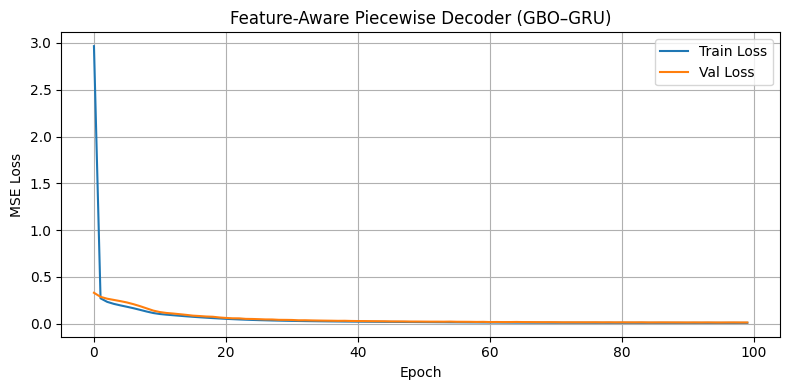

In [14]:
import os
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

os.makedirs("saved_models/piecewise_surface", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=5e-5, verbose=0),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=5, min_lr=1e-7),
   ModelCheckpoint("saved_models/piecewise_surface/decoder_bs_loss_fwpca.keras", save_best_only=True)
]

history = decoder_pw.fit(
   x=X_train,
   y=y_train,
   validation_data=(X_val, y_val),
   batch_size=32,
   epochs=100,
   callbacks=callbacks,
   verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Feature-Aware Piecewise Decoder (FW-PCA–GRU)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
Piecewise Decoder with BS Loss - FW-PCA RMSE_σ: 0.0084
RMSE by maturity (mean ± std): 0.0086 ± 0.0054
RMSE by strike    (mean ± std): 0.0101 ± 0.0015
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


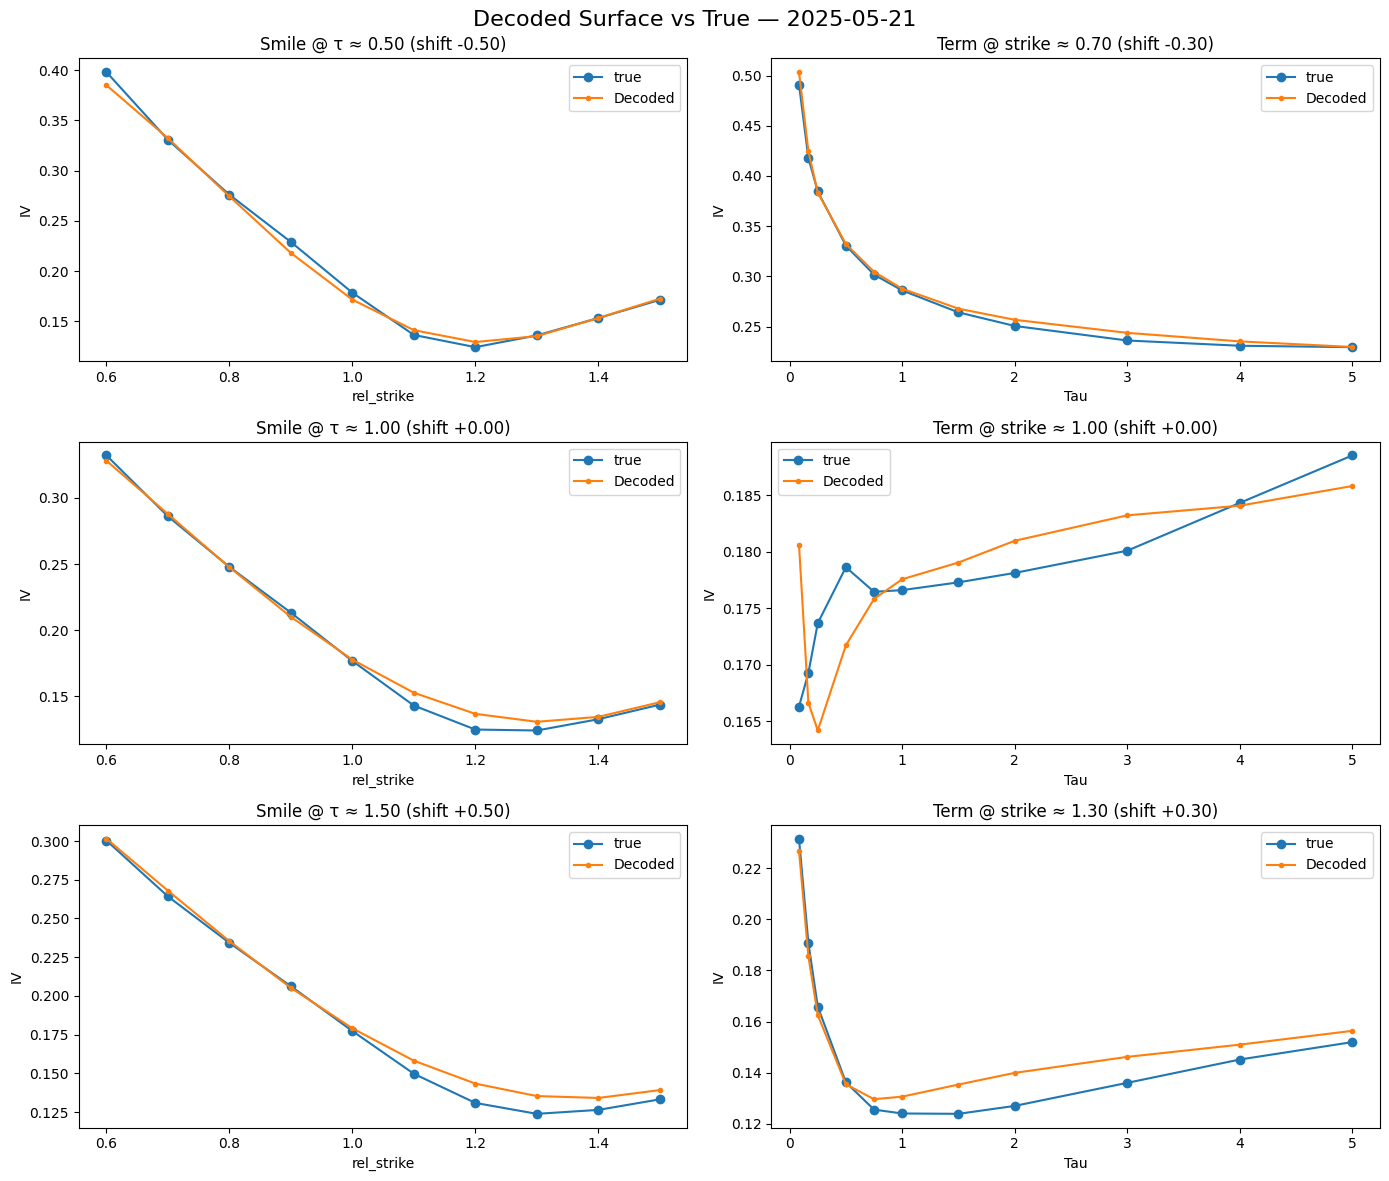

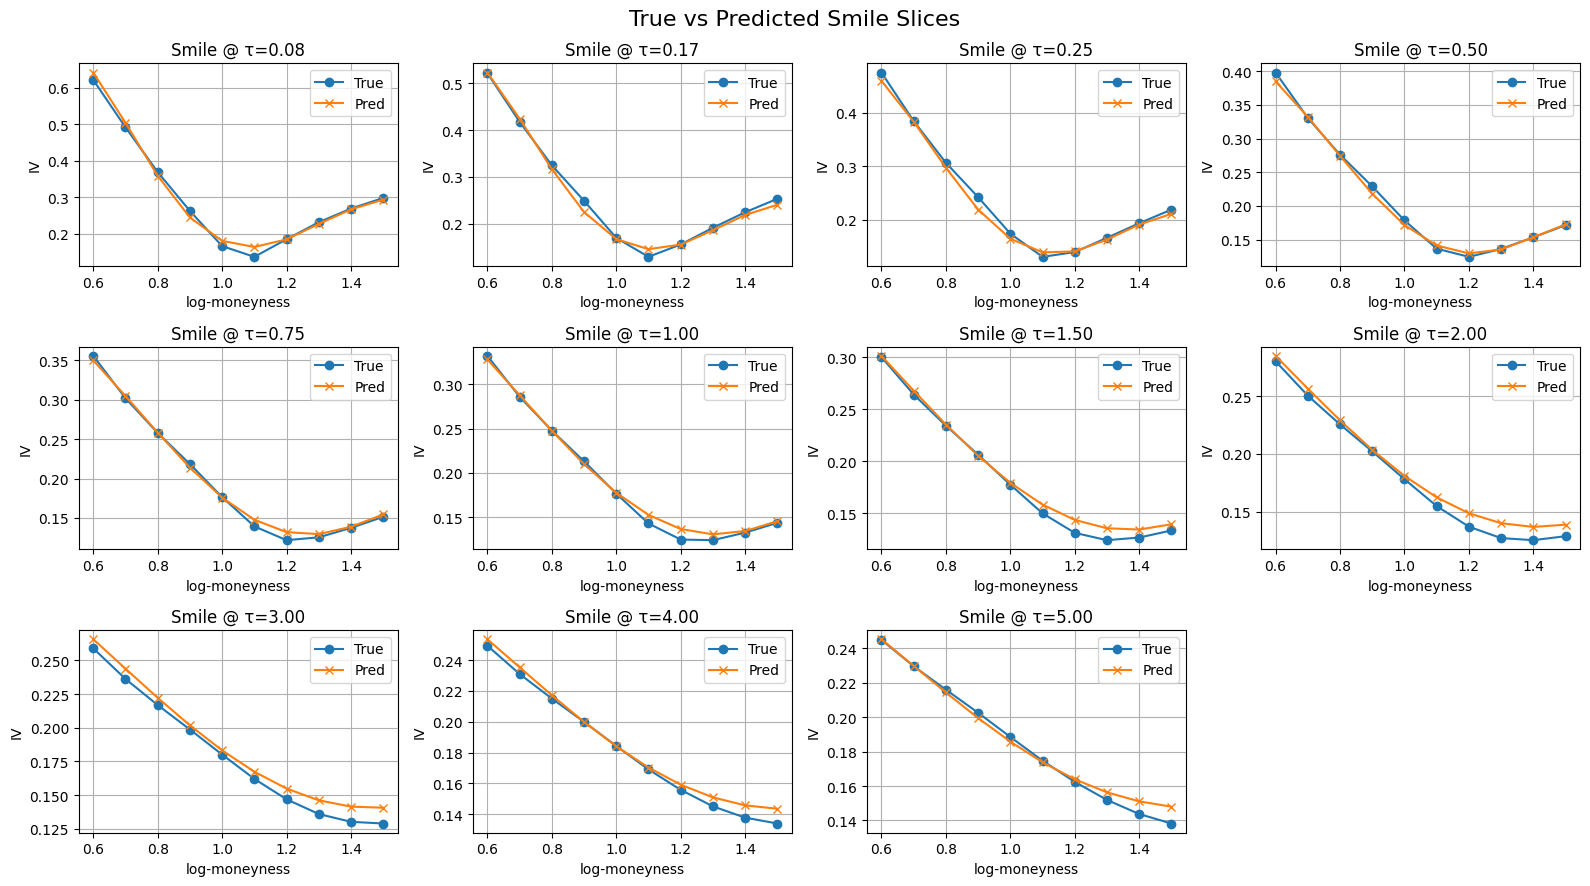

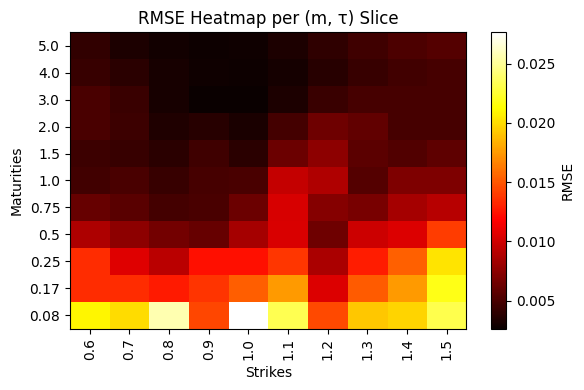

{'rmse_overall': 0.008414856,
 'rmse_by_maturity': array([0.02125228, 0.01542551, 0.01327214, 0.00917641, 0.00717251,
        0.00641375, 0.00531445, 0.00482098, 0.00417536, 0.00386129,
        0.00398391], dtype=float32),
 'rmse_by_strike': array([0.00974603, 0.00900607, 0.00976004, 0.00795613, 0.01101408,
        0.01146157, 0.00806366, 0.00986933, 0.01080658, 0.01310967],
       dtype=float32)}

In [15]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike tau grid
m_grid, tau_grid = np.meshgrid(
    ops.convert_to_numpy(tensors["strike_tensor"]),
    ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
    decoder_pw.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")

# evaluate with new function
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # precomputed predictions (N, M, K)
    Y_true=Y_full,                         # ground truth (N, M*K) auto reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw,                    # for penalty calc
    title="Piecewise Decoder with BS Loss - FW-PCA"
)

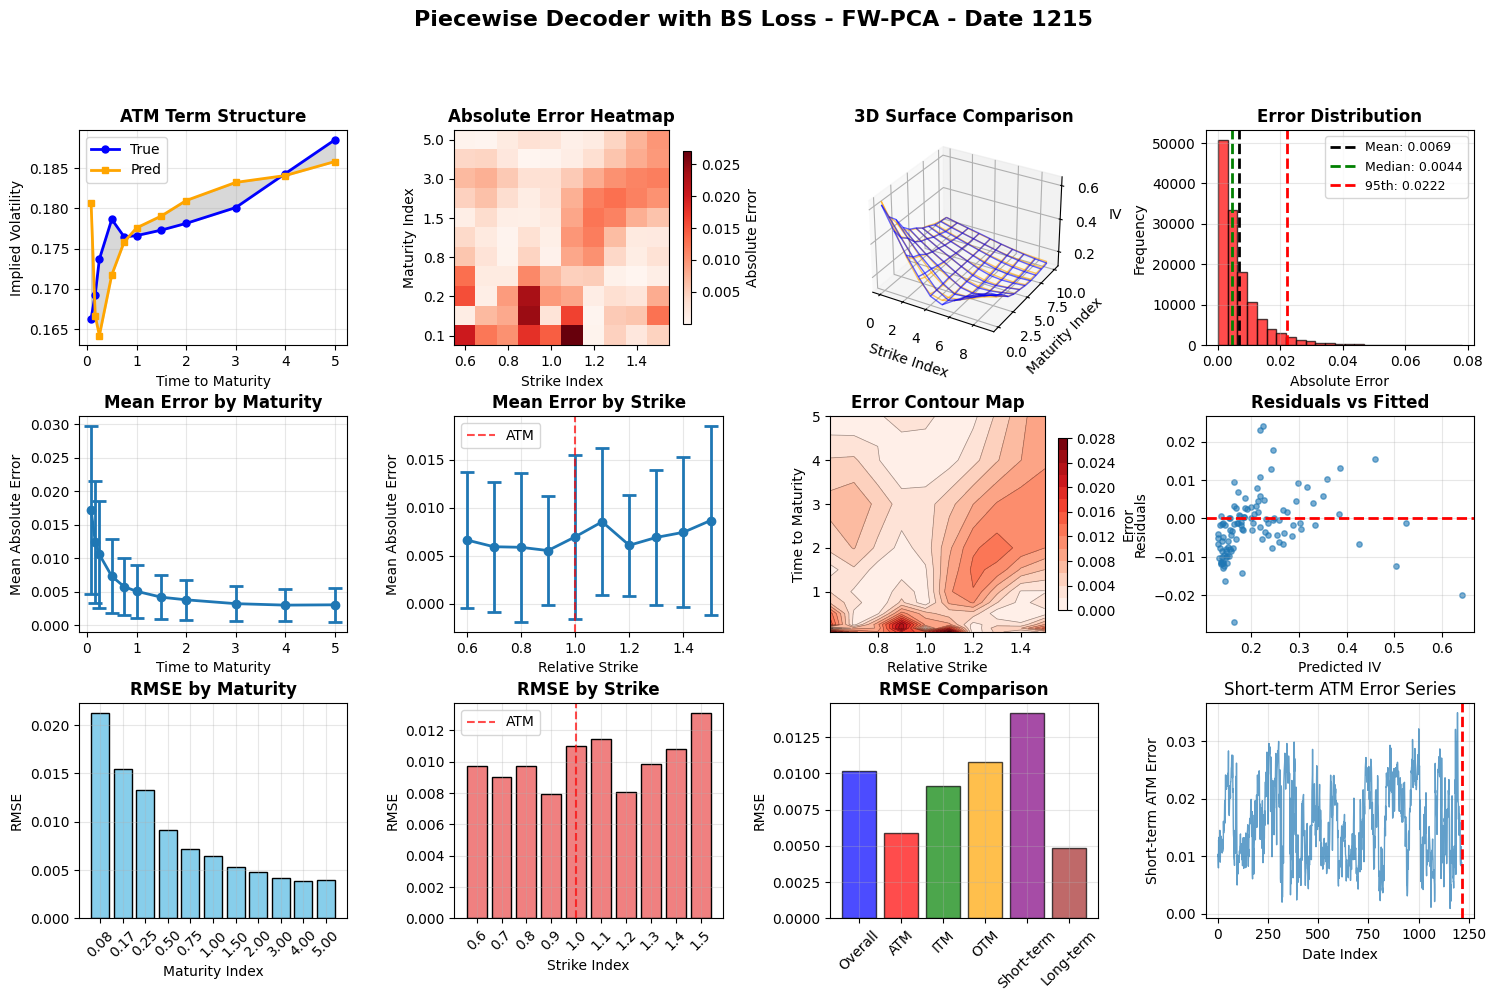

Overall Performance Category Performance  \
RMSE                           0.010190                  NaN   
MAE                            0.006868                  NaN   
Max Error                      0.078045                  NaN   
Mean Error                     0.006868                  NaN   
Median Error                   0.004409                  NaN   
95th Percentile                0.022209                  NaN   
ATM RMSE                            NaN             0.005872   
ITM RMSE                            NaN             0.009147   
OTM RMSE                            NaN             0.010793   
Short-term RMSE                     NaN             0.014152   
Long-term RMSE                      NaN             0.004845   
Short/Long Ratio                    NaN                2.921   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=4.00 (RMSE: 0.003861)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.021252)                       NaN  
Best Strike           K=0.9 (RMSE: 0.007956)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.013110)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.011014)                       NaN  
Overall Rank              ATM ranks #3 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.921)  
ATM Issues                               NaN   NO (ATM/Overall: 0.58x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001646)  
High Error Variance                      NaN       YES (std: 0.007528)  
Model Quality                            NaN                      GOOD  
Recommendation                           NaN         Needs Improvement

In [16]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike tau grid
m_grid, tau_grid = np.meshgrid(
    ops.convert_to_numpy(tensors["strike_tensor"]),
    ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
    decoder_pw.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match predictions
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run comprehensive analysis
metrics = analyze_decoder_comprehensive(
    Y_true=Y_full,              # ground truth surfaces reshaped
    Y_pred=Y_hat,               # predicted surfaces from piecewise decoder
    taus=ops.convert_to_numpy(tensors["taus"]),
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    date_idx=-1,                # last date
    dates=None,                 # optional date list for labeling
    title="Piecewise Decoder with BS Loss - FW-PCA"
)

In [17]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries


#tracking function 
summary_pw_decoder = summarize_decoder_errors(
    Y_true=Y_full, 
    Y_pred=Y_hat,
    taus=taus, 
    rel_strikes=rel_strikes,
    name="Piecewise Decoder with BS Loss-FW-PCA",
    model=decoder_pw
)


summary_all_decoders = collect_decoder_summaries(
    summary_pw_decoder,
    # add names here / check numbering 
)

display(summary_all_decoders)

Name  Rank Overall_RMSE Overall_MAE  \
0  Piecewise Decoder with BS Loss-FW-PCA     1     0.010190    0.006868   

   ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio Max_Error  \
0  0.011014  0.006970  0.009147  0.010793         2.921050  0.078045   

   Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0             True       False          GOOD             False

smoothing impact: 0.008579
Evaluation dimensions: N=10, M=11, K=10
Smoothed Piecewise Decoder (Feature-Aware) - FW-PCA RMSE_σ: 0.0156
RMSE by maturity (mean ± std): 0.0184 ± 0.0153
RMSE by strike    (mean ± std): 0.0205 ± 0.0124
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


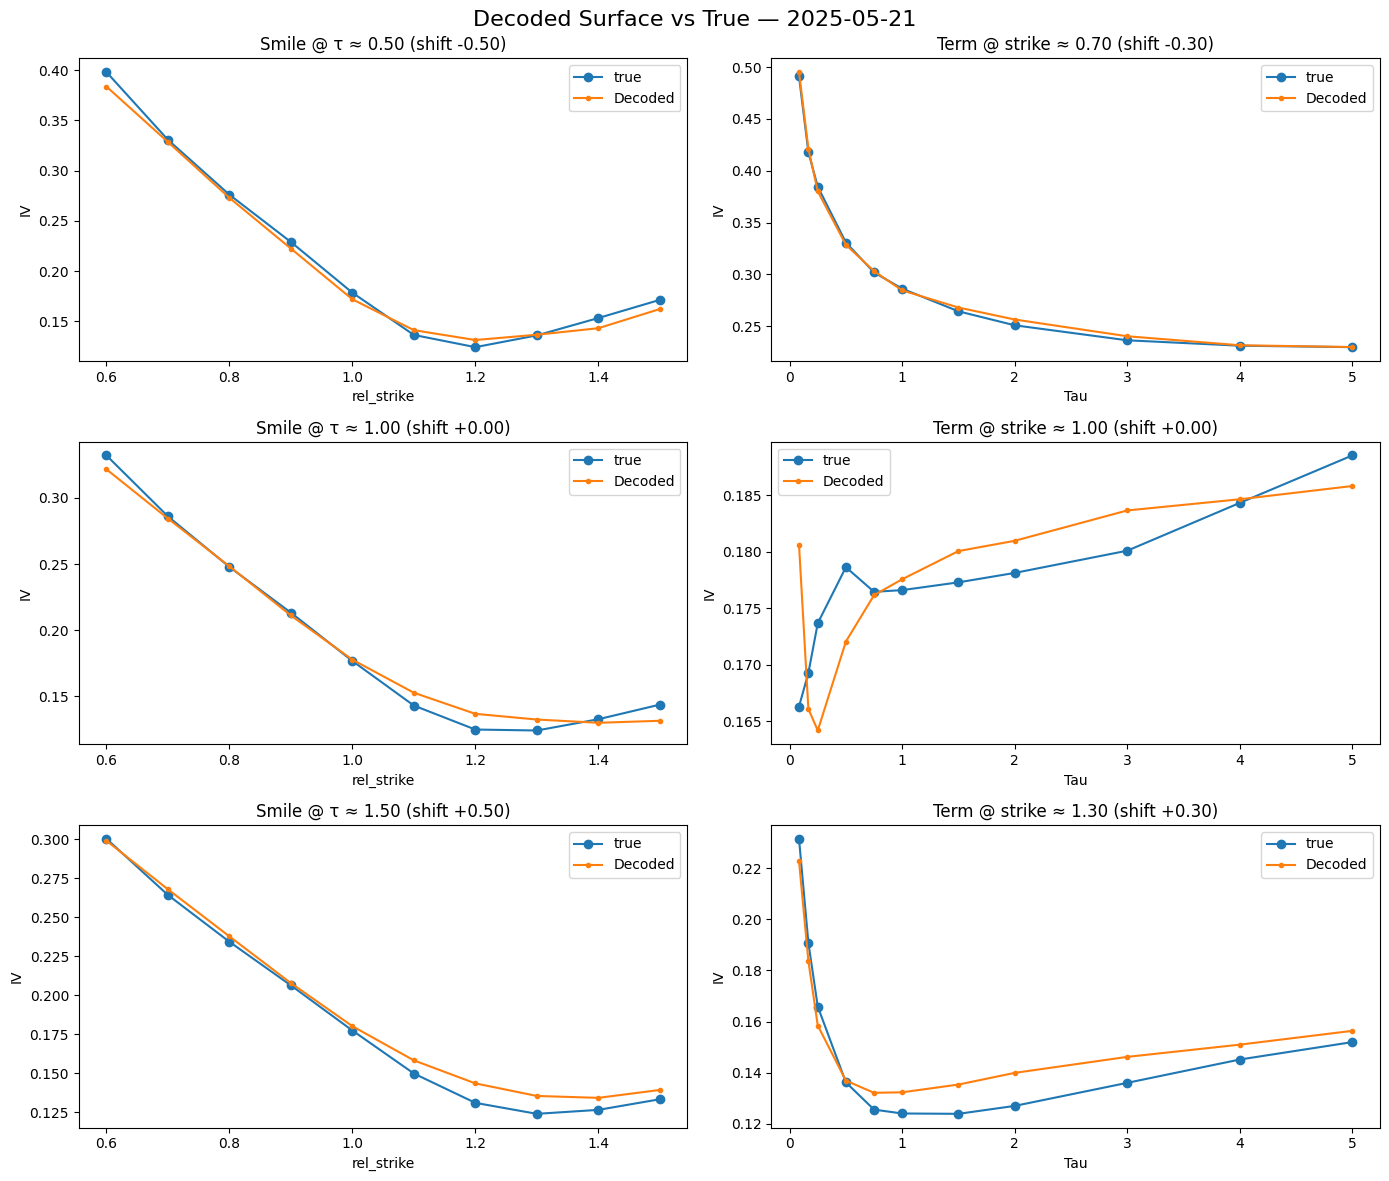

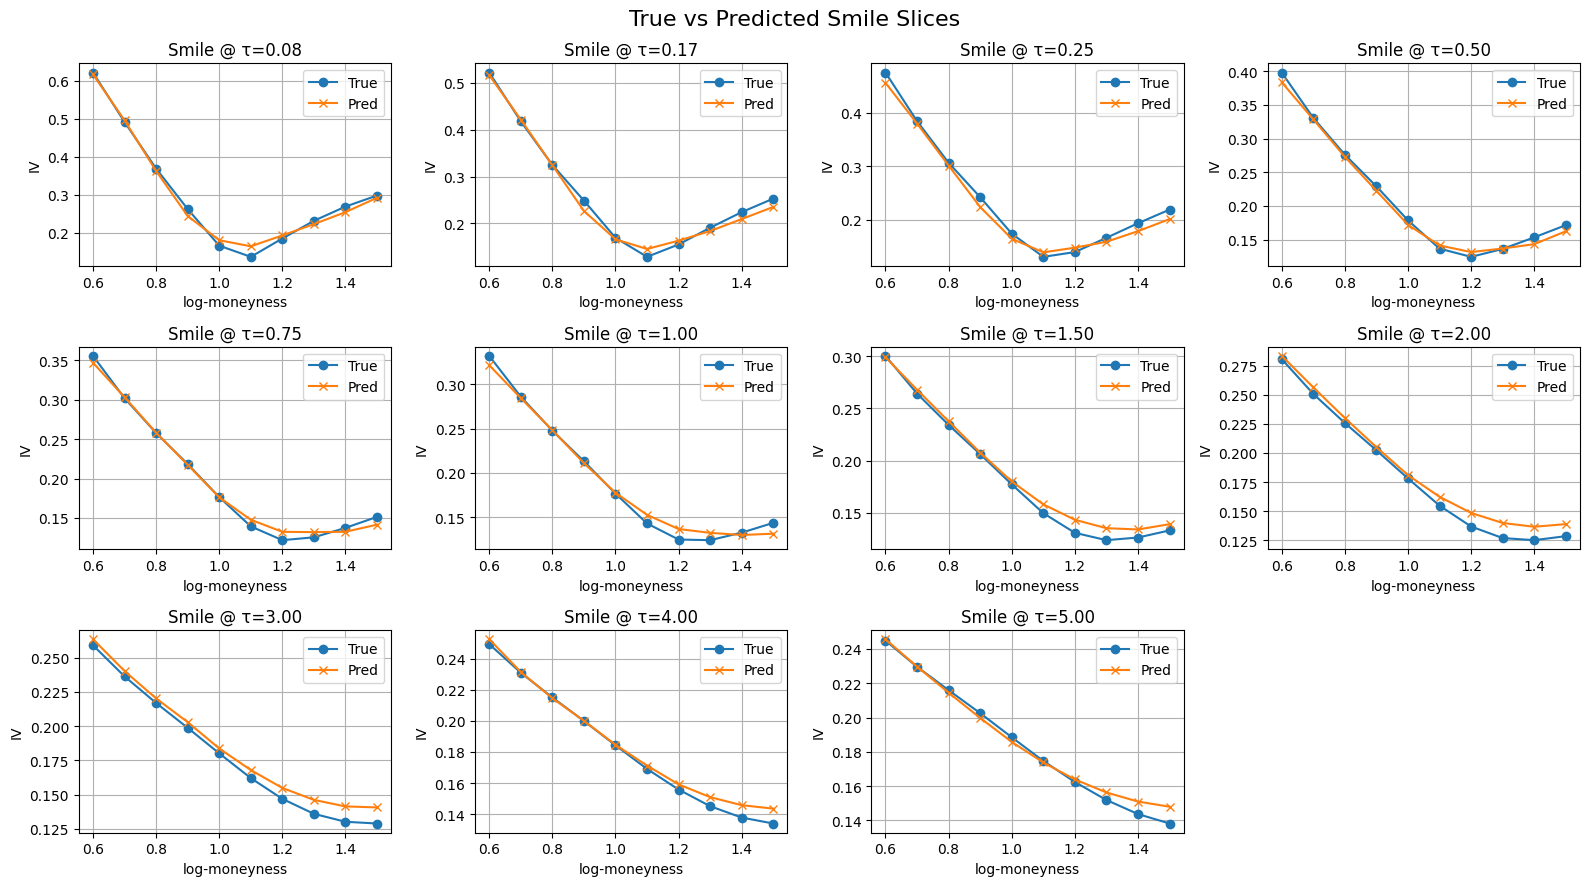

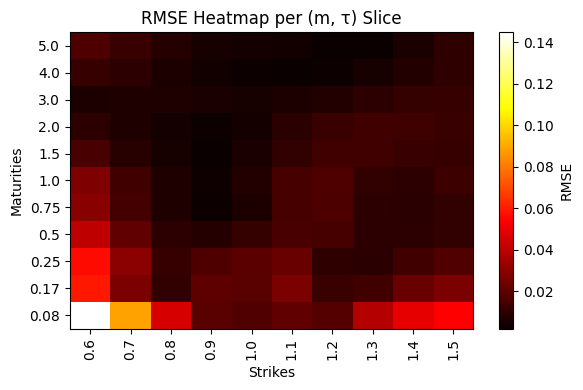

{'rmse_overall': 0.015646476840655177,
 'rmse_by_maturity': array([0.06256675, 0.02700087, 0.02453731, 0.01758544, 0.01382606,
        0.01371033, 0.01070301, 0.00964558, 0.00778703, 0.00700217,
        0.00832382]),
 'rmse_by_strike': array([0.05367162, 0.03110199, 0.01567816, 0.01038304, 0.01114304,
        0.01520989, 0.01258975, 0.01518014, 0.01873677, 0.02118835])}

In [18]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# config
SMOOTH_ALL = False
N_surfaces = 10

# select forecasted latents, features, and true surfaces
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned if SMOOTH_ALL else F_aligned[-N_surfaces:]
Y_true = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# use raw predictions from y_hat
Y_pred_raw = Y_hat if SMOOTH_ALL else Y_hat[-N_surfaces:]

# apply smoothing refinement
Y_pred_smooth = np.stack([
    decoder_pw.refine_surface(surf, lambda_cal=0.1, lambda_smile=0.1)
    for surf in Y_pred_raw
])

# calc smoothing impact
smoothing_impact = np.mean(np.abs(Y_pred_smooth - Y_pred_raw))
print(f"smoothing impact: {smoothing_impact:.6f}")

# evaluate smoothed predictions
evaluate_decoder_output_v2(
    Y_pred=Y_pred_smooth,                   # smoothed predictions (N, M, K)
    Y_true=Y_true,                          # ground truth (N, M*K) auto reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw,                     # for penalty calc
    title="Smoothed Piecewise Decoder (Feature-Aware) - FW-PCA"
)

---
---

### FINAL POINTWISE DECDOER WITH MOE OPTION 

---
---

#### Experiment 1 

Training MoE Modular Decoder
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 113s 39ms/step - loss: 3.5151 - val_loss: 0.5114 - learning_rate: 1.0000e-04
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 118s 40ms/step - loss: 0.3058 - val_loss: 0.1233 - learning_rate: 1.0000e-04
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 116s 40ms/step - loss: 0.0944 - val_loss: 0.0773 - learning_rate: 1.0000e-04
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 119s 41ms/step - loss: 0.0558 - val_loss: 0.0404 - learning_rate: 1.0000e-04
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 116s 40ms/step - loss: 0.0365 - val_loss: 0.0350 - learning_rate: 1.0000e-04
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 116s 39ms/step - loss: 0.0276 - val_loss: 0.0265 - learning_rate: 1.0000e-04
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 113s 38ms/step - loss: 0.0223 - val_loss: 0.0228 - learning_rate: 1.0000e-04
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 120s 41ms/step - loss: 0.0189 - va

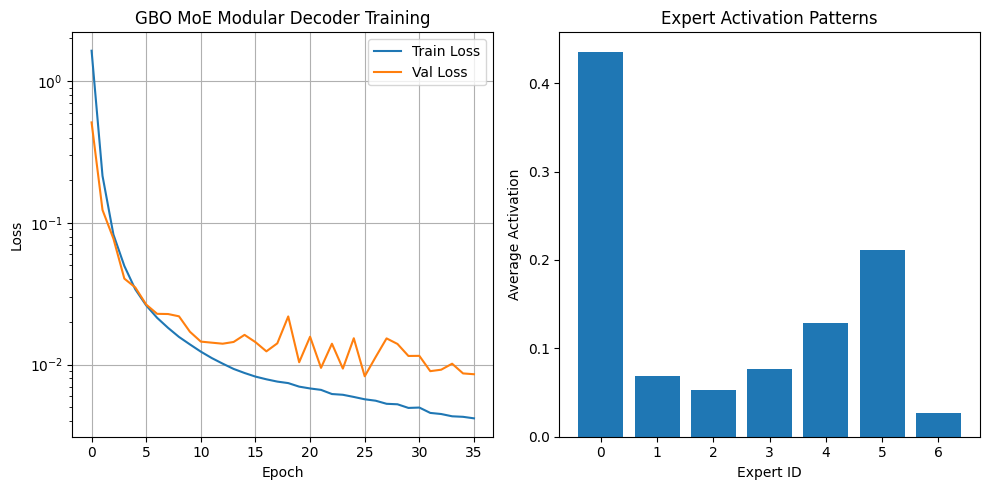

In [ ]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

USE_MOE = True

print(f"Training {'MoE' if USE_MOE else 'Standard'} Modular Decoder")

decoder_pw_mod = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_moe=True,
   num_experts=7,                    
   
   maturity_experts=4,               
   free_experts=3,                   
   maturity_specialization=True,
   
   atm_specialization=False,         
   atm_loss_weight=1.0,
   
   lambda_diversity=0.25,
)

decoder_pw_mod.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/piecewise_surface_mod_{model_suffix}/decoder_fwpca.keras", save_best_only=True, verbose=0)
]

history = decoder_pw_mod.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"FW-PCA {'MoE' if USE_MOE else 'Standard'} Modular Decoder Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   analysis = decoder_pw_mod.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod.num_experts), analysis['expert_activations'])
       plt.title("Expert Activation Patterns")
       plt.xlabel("Expert ID")
       plt.ylabel("Average Activation")
       plt.xticks(range(decoder_pw_mod.num_experts))
       
       print(f"\nExpert Analysis:")
       print(f"  Expert activations: {analysis['expert_activations']}")
       print(f"  Average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
Piecewise Decoder with BS Loss - FW-PCA (MoE) RMSE_σ: 0.0064
RMSE by maturity (mean ± std): 0.0067 ± 0.0035
RMSE by strike    (mean ± std): 0.0072 ± 0.0023
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


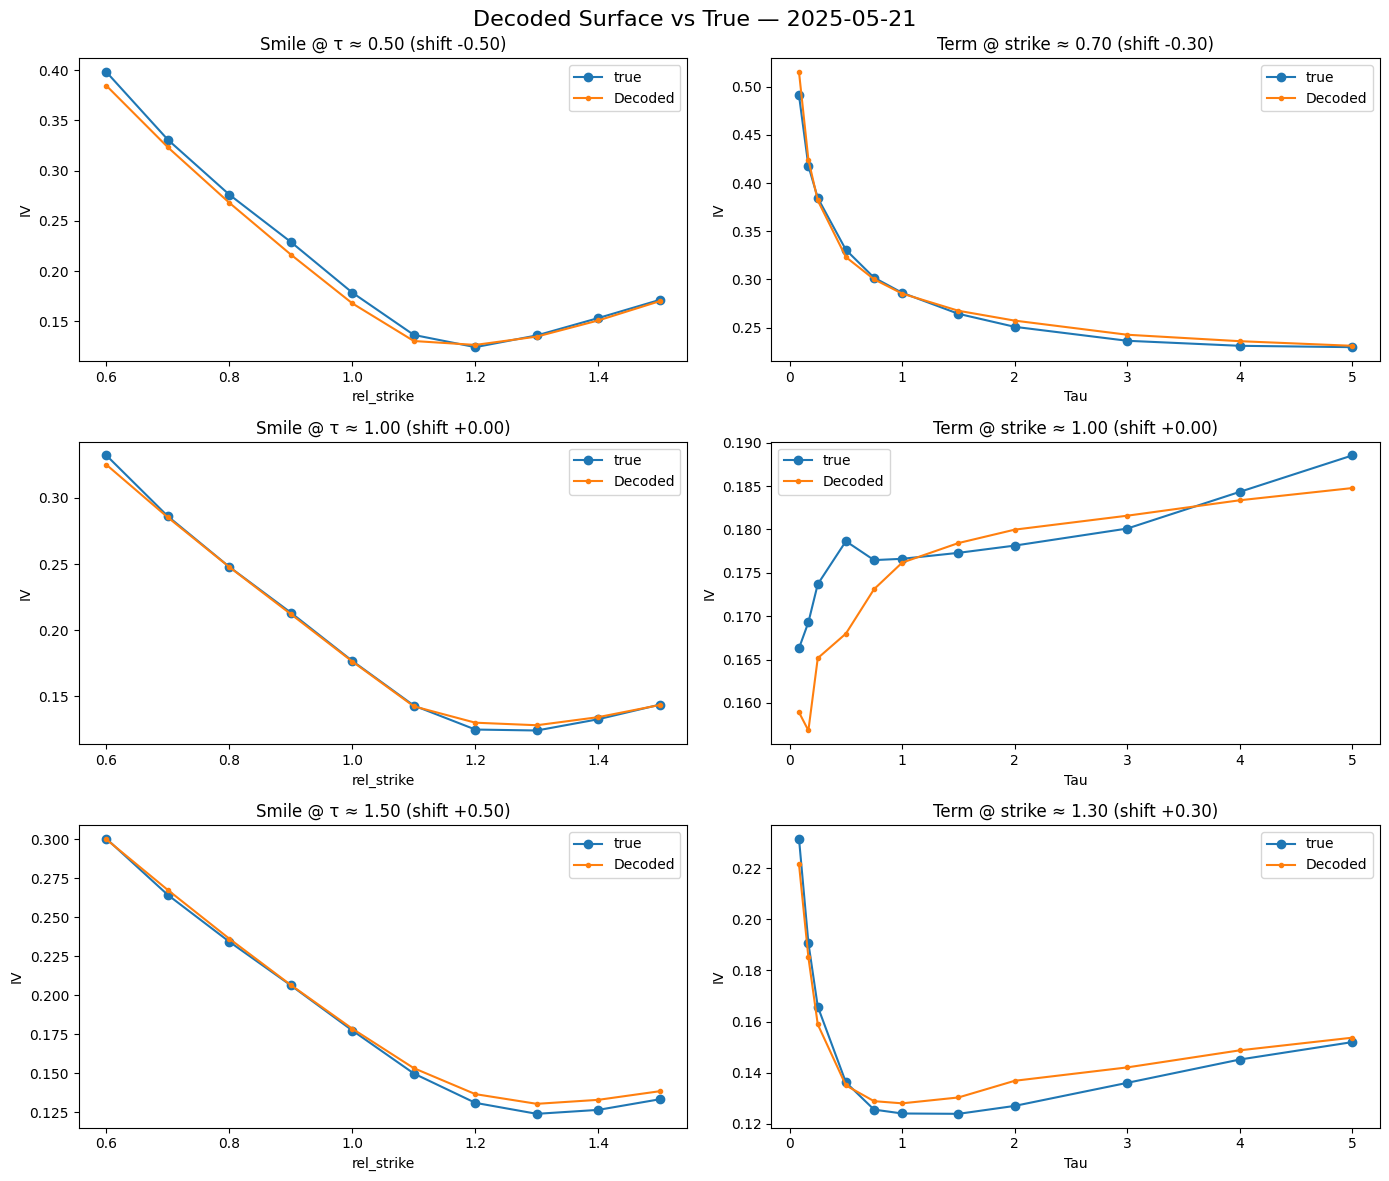

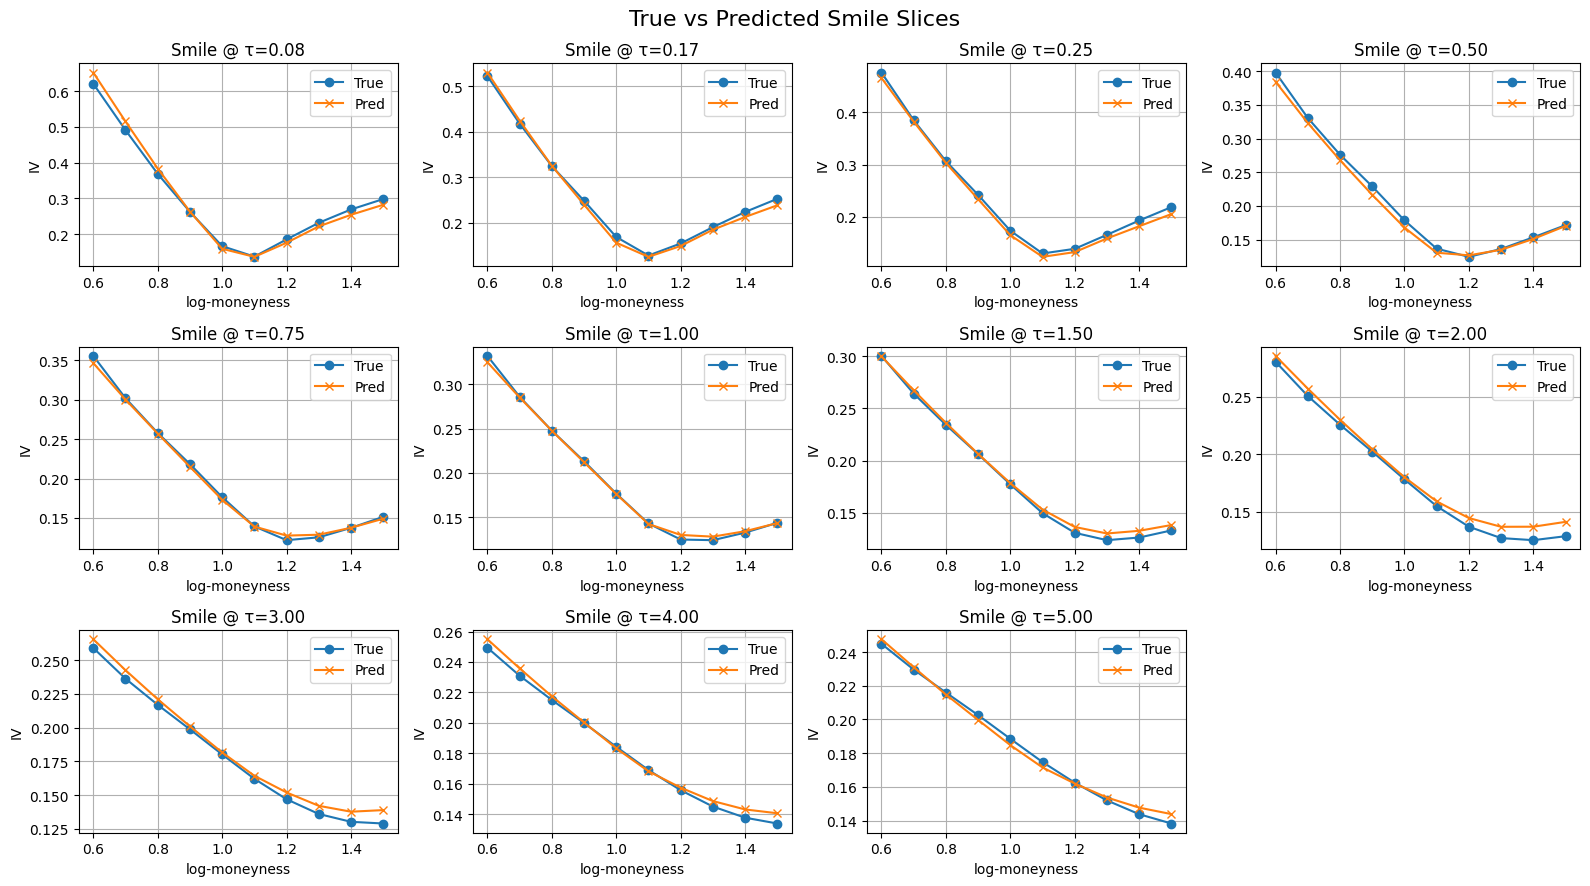

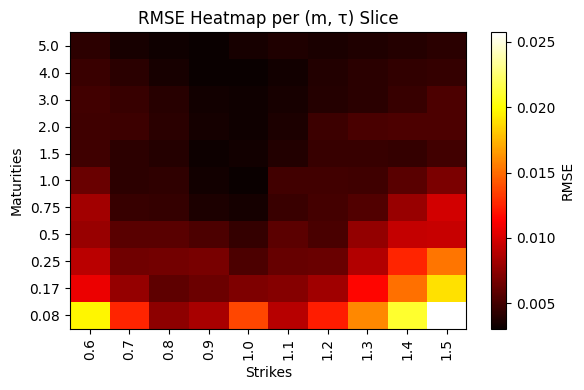

{'rmse_overall': 0.0064313347,
 'rmse_by_maturity': array([0.01564643, 0.01068789, 0.00889567, 0.00691471, 0.0061053 ,
        0.00502295, 0.00427681, 0.00455832, 0.00424472, 0.00394411,
        0.00375229], dtype=float32),
 'rmse_by_strike': array([0.00886496, 0.00623393, 0.0050677 , 0.00491699, 0.00575207,
        0.00539161, 0.00620513, 0.00783193, 0.01007193, 0.01211272],
       dtype=float32)}

In [20]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike tau grid
m_grid, tau_grid = np.meshgrid(
    ops.convert_to_numpy(tensors["strike_tensor"]),
    ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
    decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")

# evaluate using new function
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # precomputed predictions (N, M, K)
    Y_true=Y_full,                         # ground truth (N, M*K) auto reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod,                # for penalty calc
    title="Piecewise Decoder with BS Loss - FW-PCA (MoE)"
)

MoE Analysis
Experts: 7
Diversity: 0.25


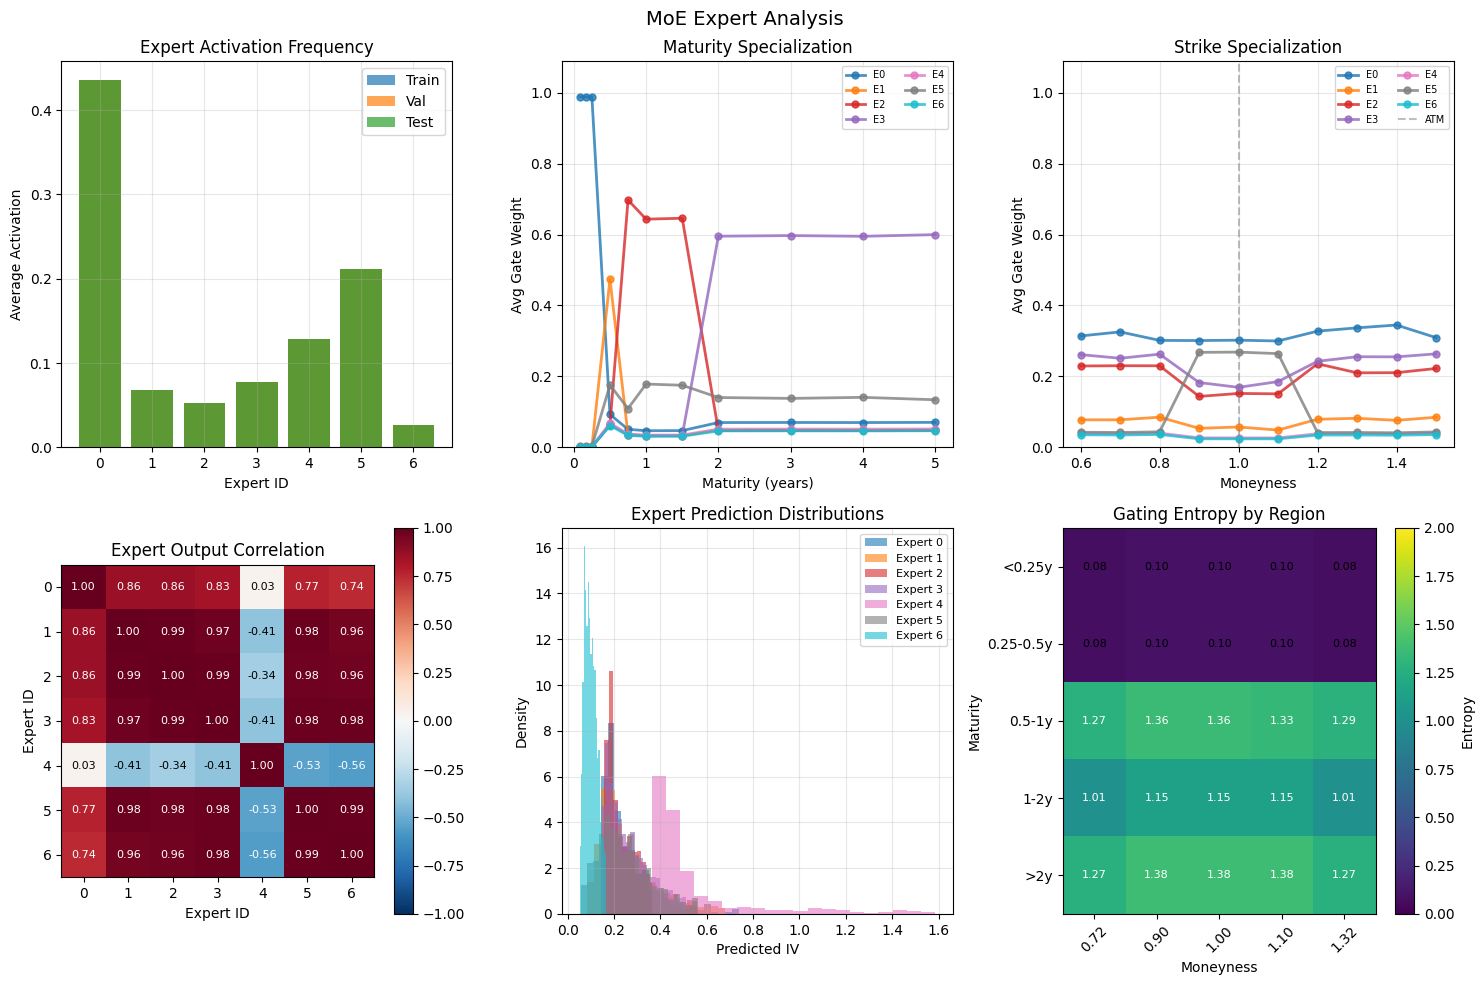


Summary:
Most active expert: 0
Least active expert: 6
Balance score: 0.868
Avg entropy: 1.586
Min correlation: -0.557
Max correlation: 0.990


In [21]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod,    # moe decoder
   X_train,           # training inputs [z+f, strikes, taus]
   X_val,             # validation inputs
   X_test,            # test inputs  
   y_train,           # training targets
   y_val,             # validation targets
   y_test             # test targets
)

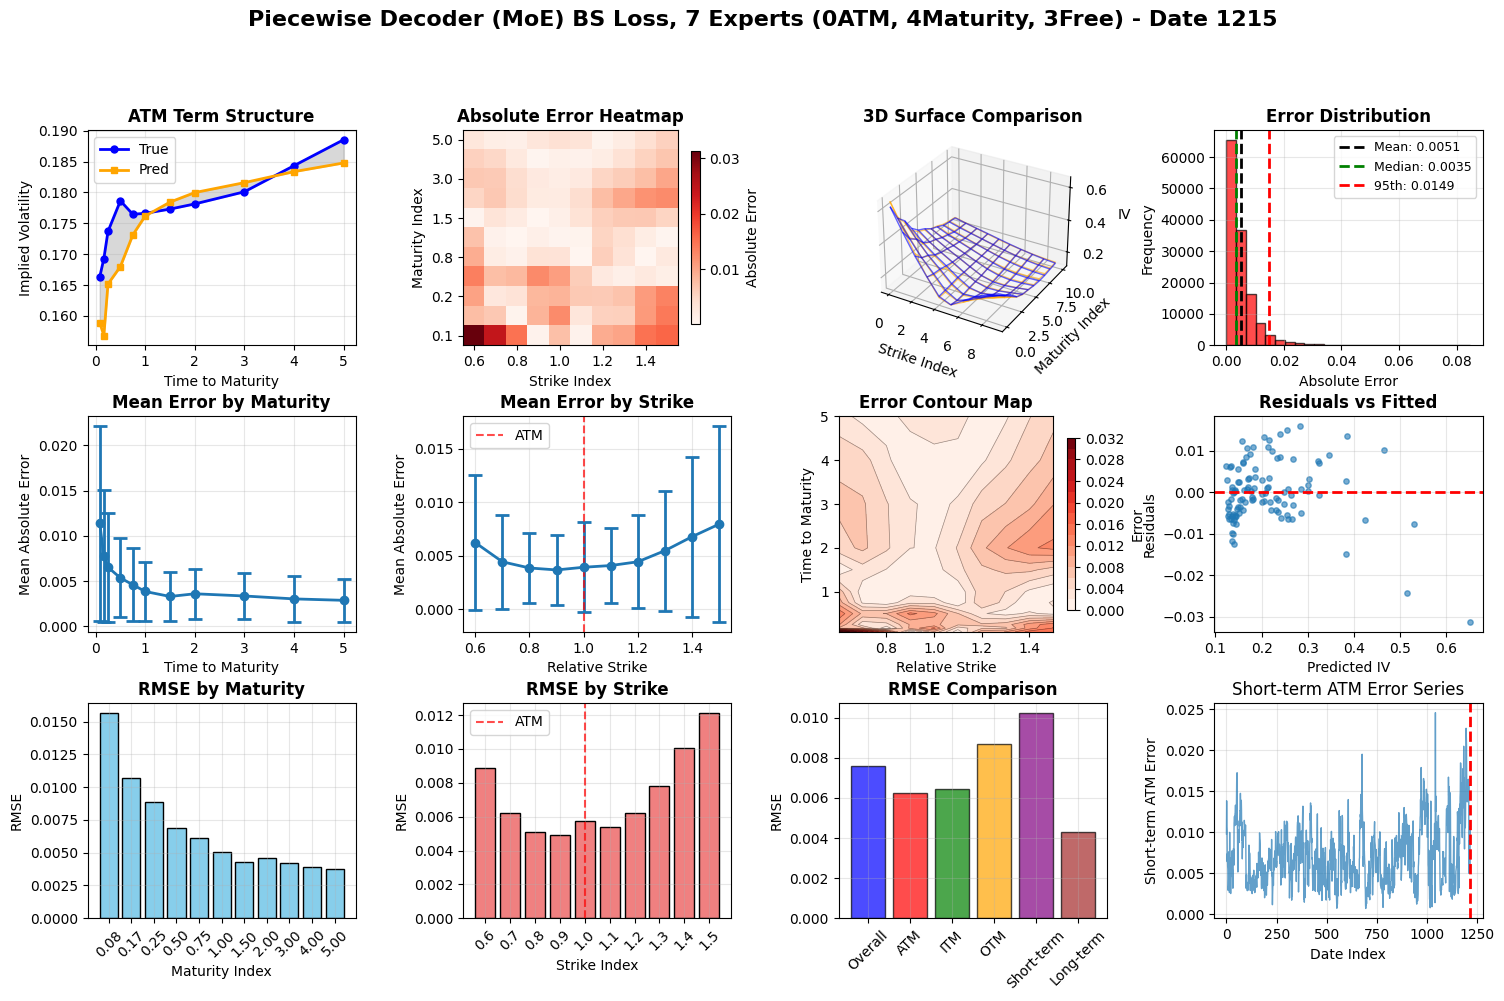

Overall Performance Category Performance  \
RMSE                           0.007599                  NaN   
MAE                            0.005074                  NaN   
Max Error                      0.084807                  NaN   
Mean Error                     0.005074                  NaN   
Median Error                   0.003494                  NaN   
95th Percentile                0.014923                  NaN   
ATM RMSE                            NaN             0.006248   
ITM RMSE                            NaN             0.006467   
OTM RMSE                            NaN             0.008684   
Short-term RMSE                     NaN             0.010230   
Long-term RMSE                      NaN             0.004320   
Short/Long Ratio                    NaN                2.368   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.003752)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.015646)                       NaN  
Best Strike           K=0.9 (RMSE: 0.004917)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.012113)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.005752)                       NaN  
Overall Rank              ATM ranks #7 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.368)  
ATM Issues                               NaN   NO (ATM/Overall: 0.82x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.002217)  
High Error Variance                      NaN       YES (std: 0.005657)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [22]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike tau grid
m_grid, tau_grid = np.meshgrid(
    ops.convert_to_numpy(tensors["strike_tensor"]),
    ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
    decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match predictions
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run comprehensive analysis
metrics = analyze_decoder_comprehensive(
    Y_true=Y_full,              # ground truth surfaces reshaped
    Y_pred=Y_hat,               # predicted surfaces from piecewise decoder
    taus=ops.convert_to_numpy(tensors["taus"]),
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    date_idx=-1,                # last date
    dates=None,                 # optional date list for labeling
    title="Piecewise Decoder (MoE) BS Loss, 7 Experts (0ATM, 4Maturity, 3Free)"
)

In [23]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name="Piecewise Decoder with BS Loss (MoE) 7 Experts, atm 0, 3 Free, 4 Maturity",
   model=decoder_pw_mod
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0  Piecewise Decoder with BS Loss (MoE) 7 Experts...     1     0.007599   
1              Piecewise Decoder with BS Loss-FW-PCA     2     0.010190   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005074  0.005752  0.003913  0.006467  0.008684         2.368279   
1    0.006868  0.011014  0.006970  0.009147  0.010793         2.921050   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.084807             True       False     EXCELLENT             False  
1  0.078045             True       False          GOOD             False

raw predictions shape: (20, 11, 10)
using sliding window size: 5
Evaluation dimensions: N=20, M=11, K=10
MoE Decoder with Surface Refinement RMSE_σ: 0.0070
RMSE by maturity (mean ± std): 0.0078 ± 0.0062
RMSE by strike    (mean ± std): 0.0090 ± 0.0043
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


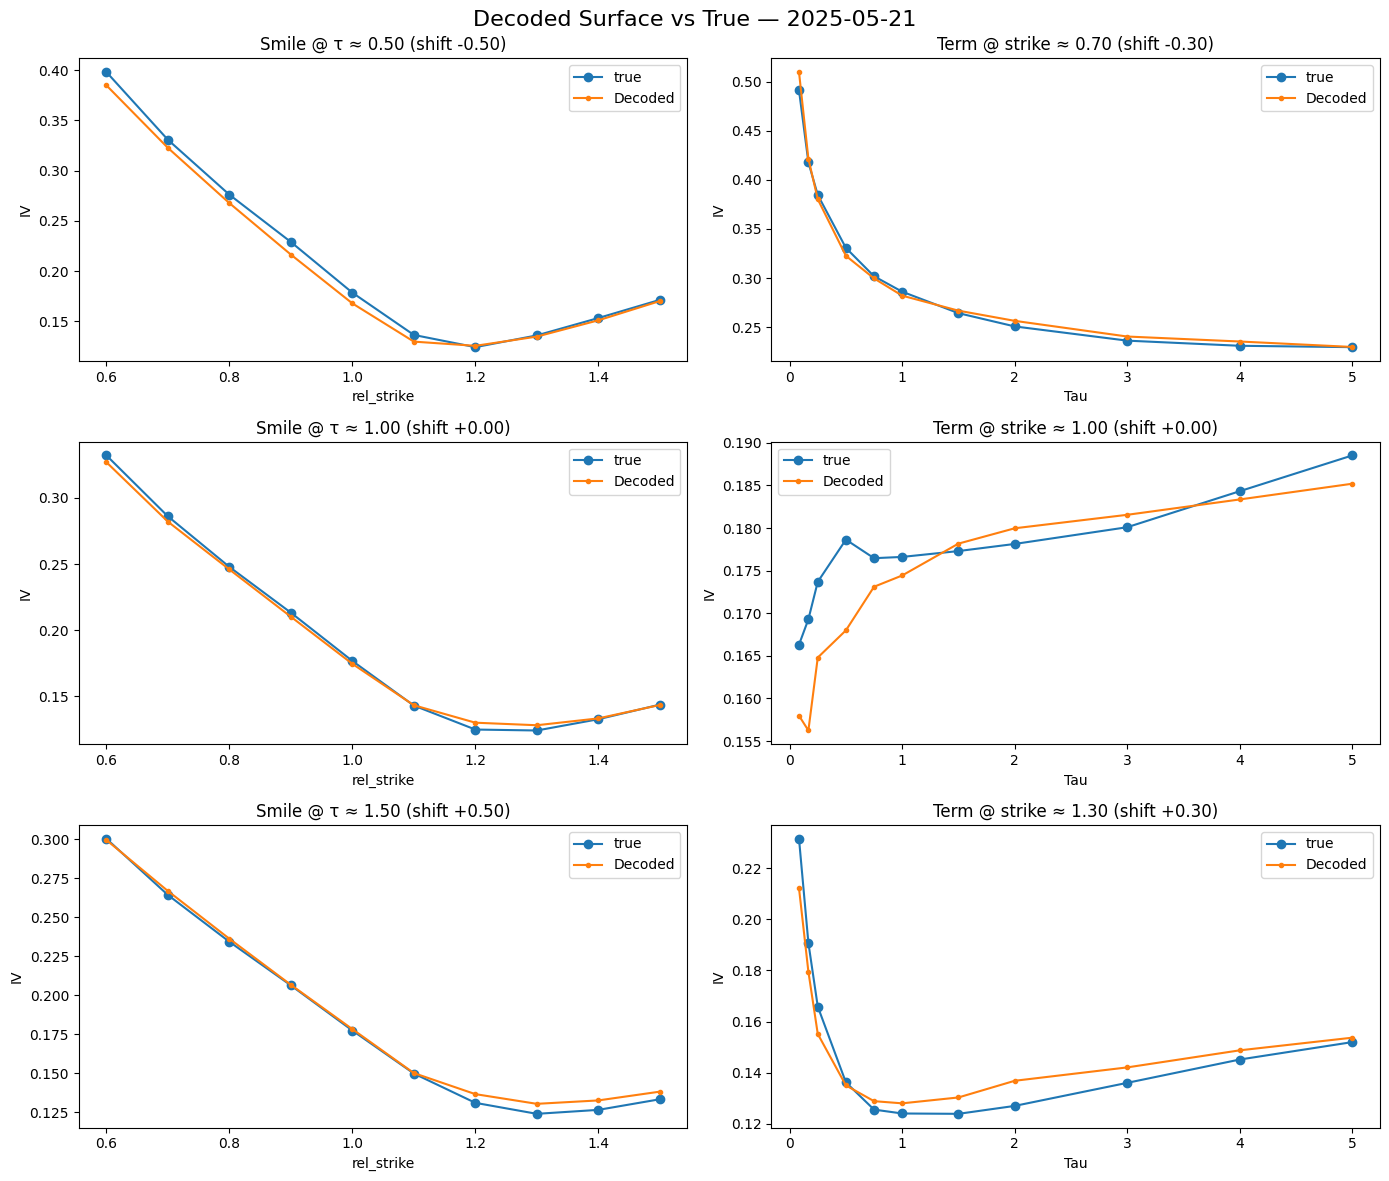

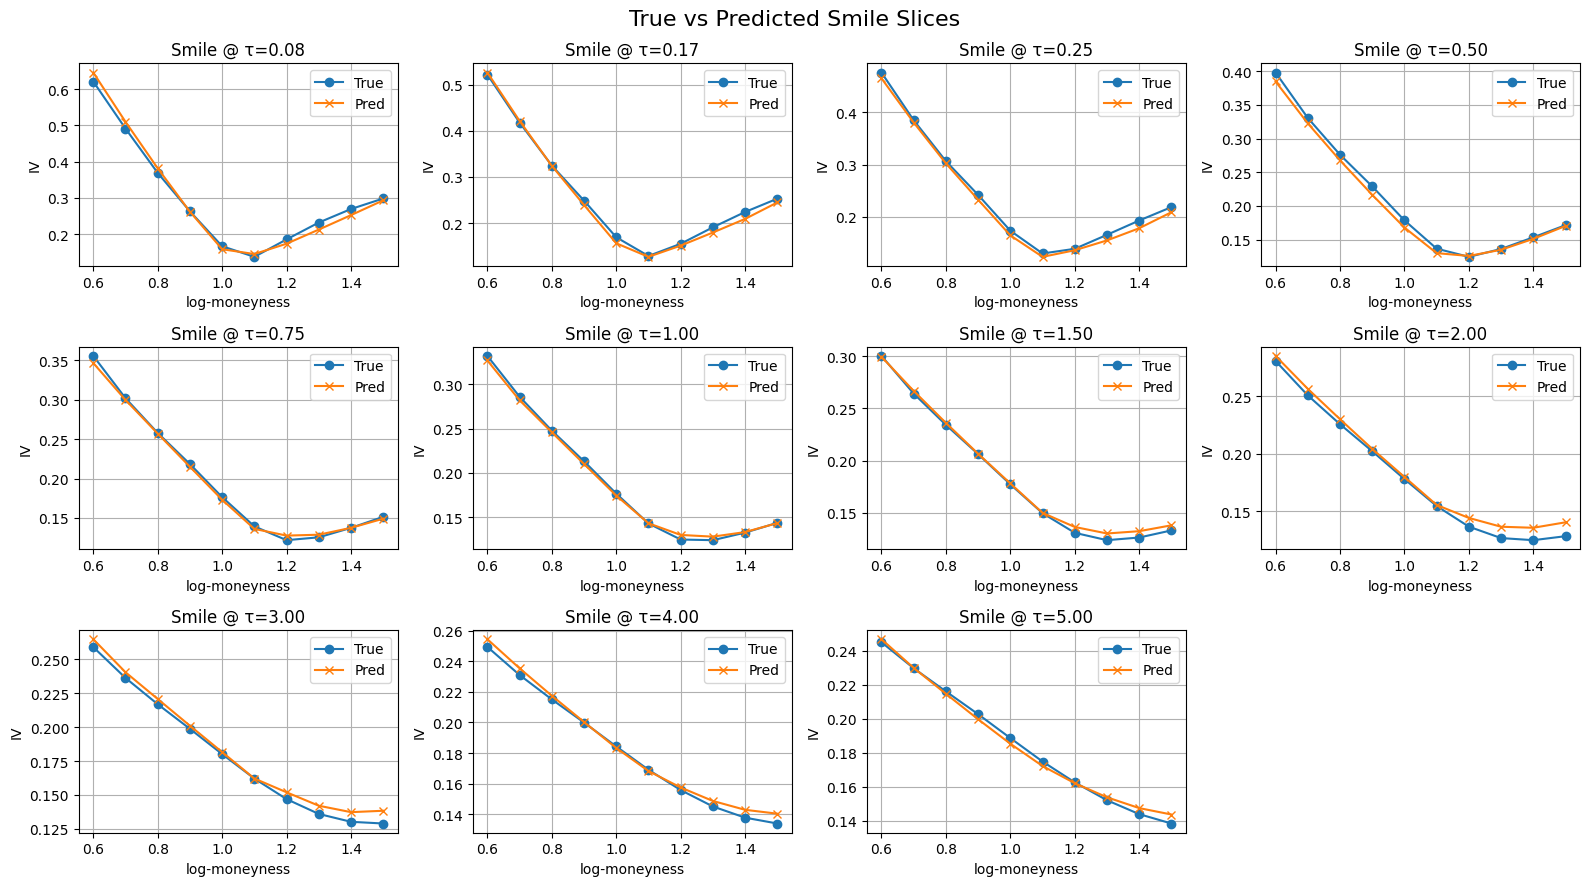

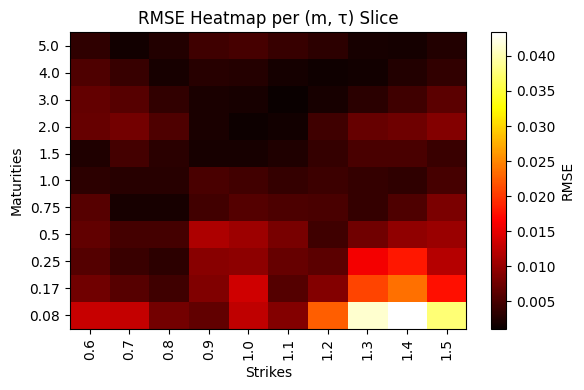

{'rmse_overall': 0.00696344829361756,
 'rmse_by_maturity': array([0.02484967, 0.01336037, 0.01017432, 0.0082035 , 0.00516039,
        0.00400916, 0.003715  , 0.00591356, 0.00422094, 0.0031053 ,
        0.00329367]),
 'rmse_by_strike': array([0.00670395, 0.00597866, 0.00419229, 0.00619718, 0.00760083,
        0.00521024, 0.00819525, 0.0152753 , 0.01654535, 0.01418021])}

In [24]:
import importlib
import utils.eval
importlib.reload(utils.eval)

import models.pointwise_moe
importlib.reload(models.pointwise_moe)

from utils.eval import evaluate_decoder_output_v2

# config
SMOOTH_ALL = False
N_surfaces = 20

# select latent forecasts, features, and true surfaces
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned if SMOOTH_ALL else F_aligned[-N_surfaces:]
Y_true = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# generate raw predictions from moe decoder
Y_pred_raw = np.stack([
    decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_eval, F_eval)
])

print(f"raw predictions shape: {Y_pred_raw.shape}")

# prepare ground truth for sliding window (3d format)
Y_true_3d = Y_true.reshape(-1, M, K)

# apply adaptive surface refinement with sliding window
window_size = max(1, int(N_surfaces // 4))  # ensure at least 1
print(f"using sliding window size: {window_size}")

Y_pred_smooth = []
for i, surf in enumerate(Y_pred_raw):
    # sliding window of recent surfaces for historical pattern matching
    window_start = max(0, i - window_size)
    window_end = i + 1
    recent_surfaces = Y_true_3d[window_start:window_end]
    
    refined_surf = decoder_pw_mod.refine_surface(
        surf, 
        recent_surfaces=recent_surfaces,
        lambda_cal=0.1,        # calendar arbitrage penalty
        lambda_smile=0.1,      # smile smoothness penalty  
        lambda_history=0.05    # historical pattern matching
    )
    Y_pred_smooth.append(refined_surf)

Y_pred_smooth = np.stack(Y_pred_smooth)

# evaluate refined surfaces
evaluate_decoder_output_v2(
    Y_pred=Y_pred_smooth,                   # refined moe predictions (N, M, K)
    Y_true=Y_true,                          # ground truth (N, M*K) auto reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod,                 # moe decoder for penalty calc
    title="MoE Decoder with Surface Refinement"
)

### Experiment 2

Training MoE Modular Decoder
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 137s 47ms/step - loss: 2.7990 - val_loss: 0.3963 - learning_rate: 1.0000e-04
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 134s 46ms/step - loss: 0.2599 - val_loss: 0.1117 - learning_rate: 1.0000e-04
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 132s 45ms/step - loss: 0.0867 - val_loss: 0.0692 - learning_rate: 1.0000e-04
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 138s 47ms/step - loss: 0.0485 - val_loss: 0.0486 - learning_rate: 1.0000e-04
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 135s 46ms/step - loss: 0.0322 - val_loss: 0.0309 - learning_rate: 1.0000e-04
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 139s 48ms/step - loss: 0.0228 - val_loss: 0.0229 - learning_rate: 1.0000e-04
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 132s 45ms/step - loss: 0.0173 - val_loss: 0.0174 - learning_rate: 1.0000e-04
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 136s 47ms/step - loss: 0.0138 - va

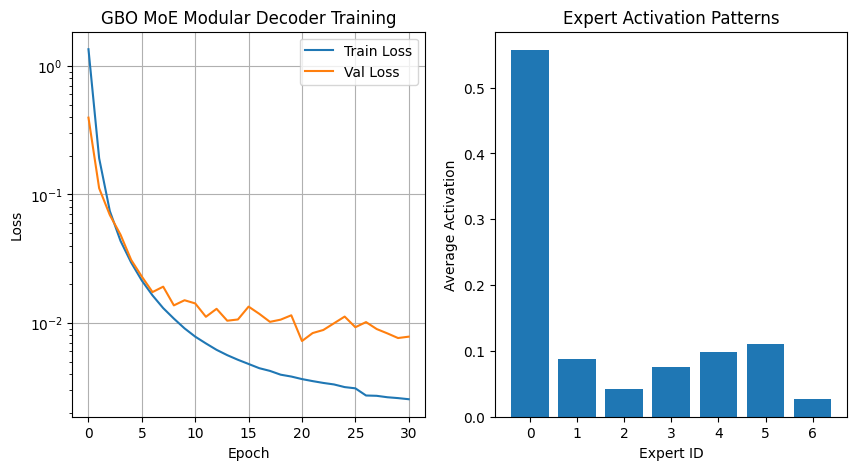

In [25]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

USE_MOE = True

print(f"Training {'MoE' if USE_MOE else 'Standard'} Modular Decoder")

decoder_pw_mod_2 = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="relu",
   use_moe=True,
   num_experts=7,                    
   
   maturity_experts=4,               
   free_experts=3,                   
   maturity_specialization=True,
   
   atm_specialization=False,         
   atm_loss_weight=1.0,
   
   lambda_diversity=1,
)

decoder_pw_mod_2.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/fwpca/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/fwpca/piecewise_surface_mod_{model_suffix}_2/decoder.keras", save_best_only=True, verbose=0)
]

history = decoder_pw_mod_2.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"FW-PCA {'MoE' if USE_MOE else 'Standard'} Modular Decoder Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   analysis = decoder_pw_mod_2.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod_2.num_experts), analysis['expert_activations'])
       plt.title("Expert Activation Patterns")
       plt.xlabel("Expert ID")
       plt.ylabel("Average Activation")
       plt.xticks(range(decoder_pw_mod_2.num_experts))

Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
piecewise moe v2 - 7exp (4mat/2free) relu div0.3 RMSE_σ: 0.0059
RMSE by maturity (mean ± std): 0.0062 ± 0.0039
RMSE by strike    (mean ± std): 0.0069 ± 0.0025
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


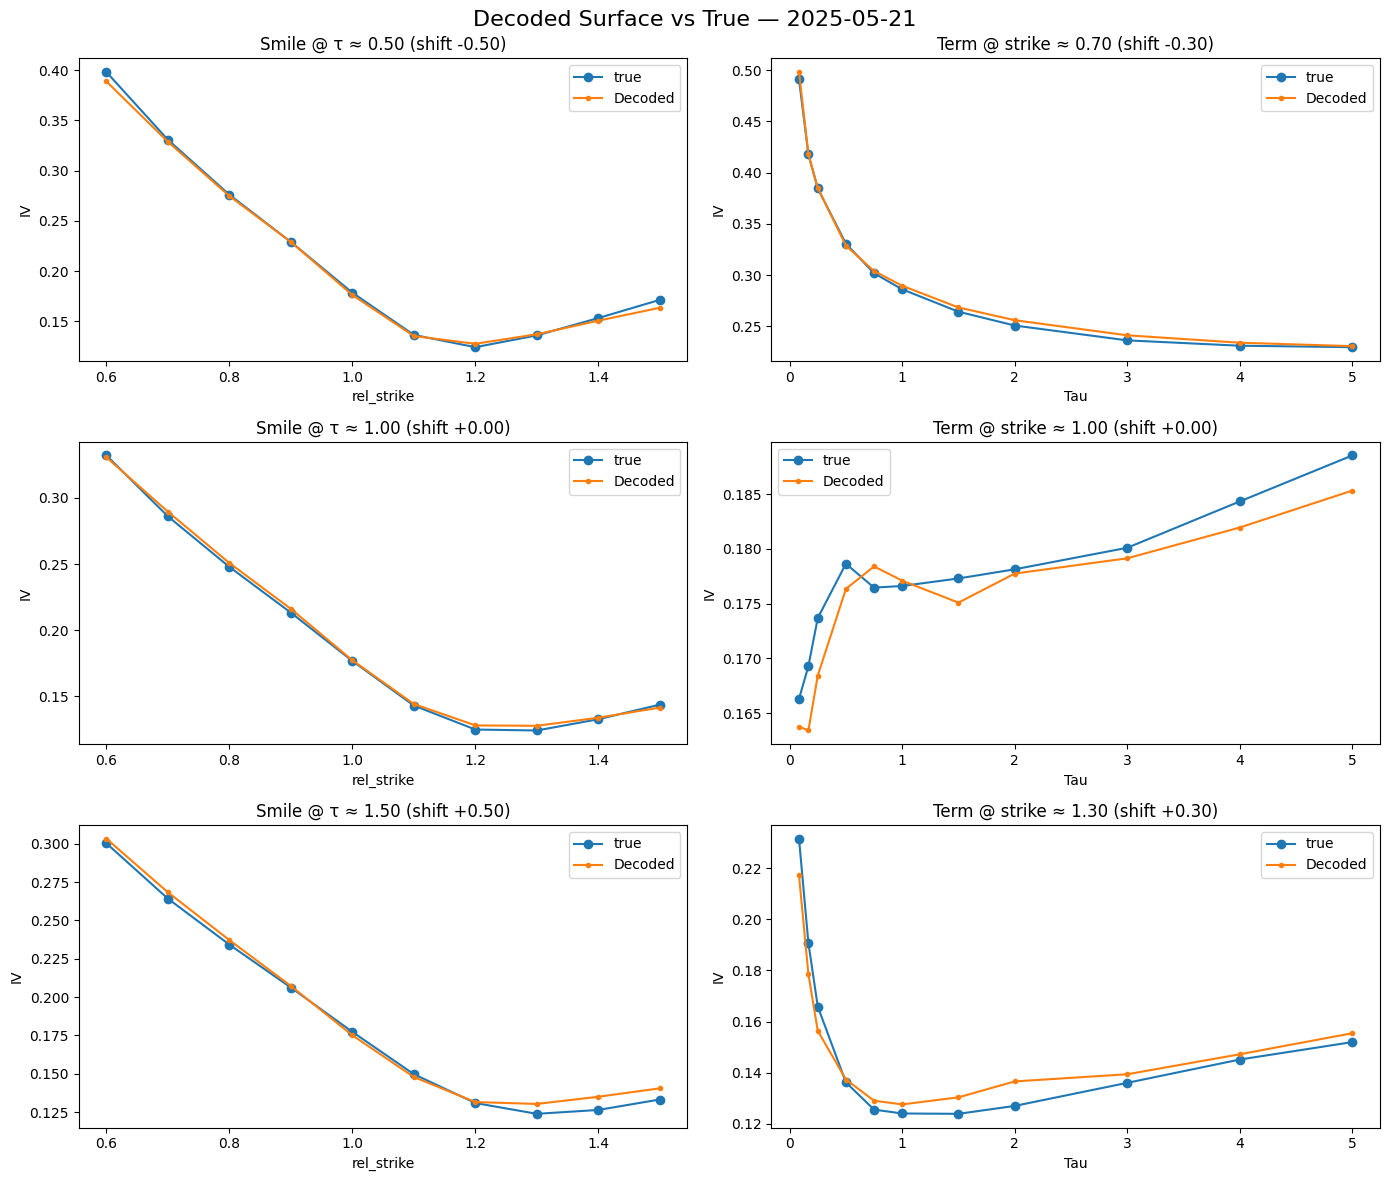

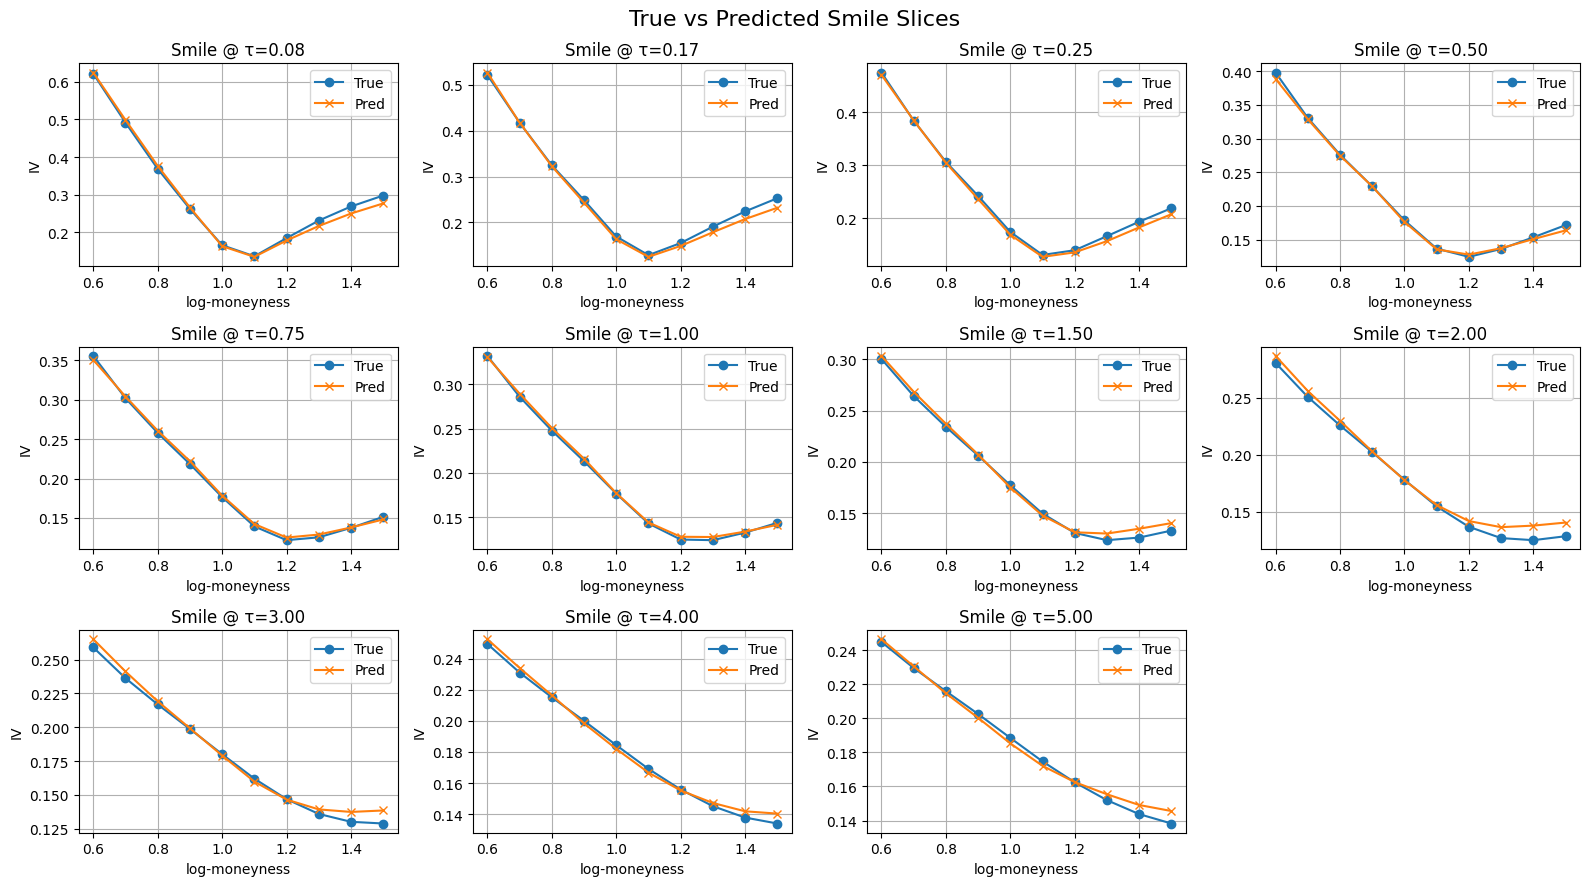

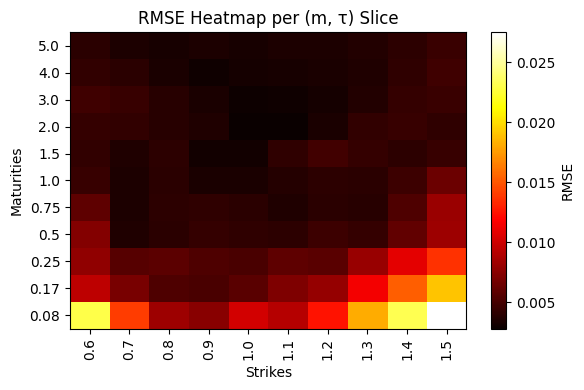

{'rmse_overall': 0.005920691,
 'rmse_by_maturity': array([0.01678578, 0.01030502, 0.00786509, 0.00528571, 0.00488088,
        0.00426943, 0.00406   , 0.00385554, 0.00389207, 0.00376659,
        0.00375142], dtype=float32),
 'rmse_by_strike': array([0.00894478, 0.00597254, 0.00475287, 0.00441438, 0.0048232 ,
        0.00496124, 0.00584496, 0.00772207, 0.00985342, 0.01199972],
       dtype=float32)}

In [26]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

name = "piecewise moe v2 - 7exp (4mat/2free) relu div0.3"

# --- Eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) - flattened ground truth

# --- Prepare strike–tau grid
m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# --- Generate predictions
Y_hat = np.stack([
   decoder_pw_mod_2.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")

# --- Evaluate using new function
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # Pre-computed predictions (N, M, K)
    Y_true=Y_full,                         # Ground truth (N, M*K) 
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod_2,                    # For penalty calculation
    title=name
)



MoE Analysis
Experts: 7
Diversity: 1


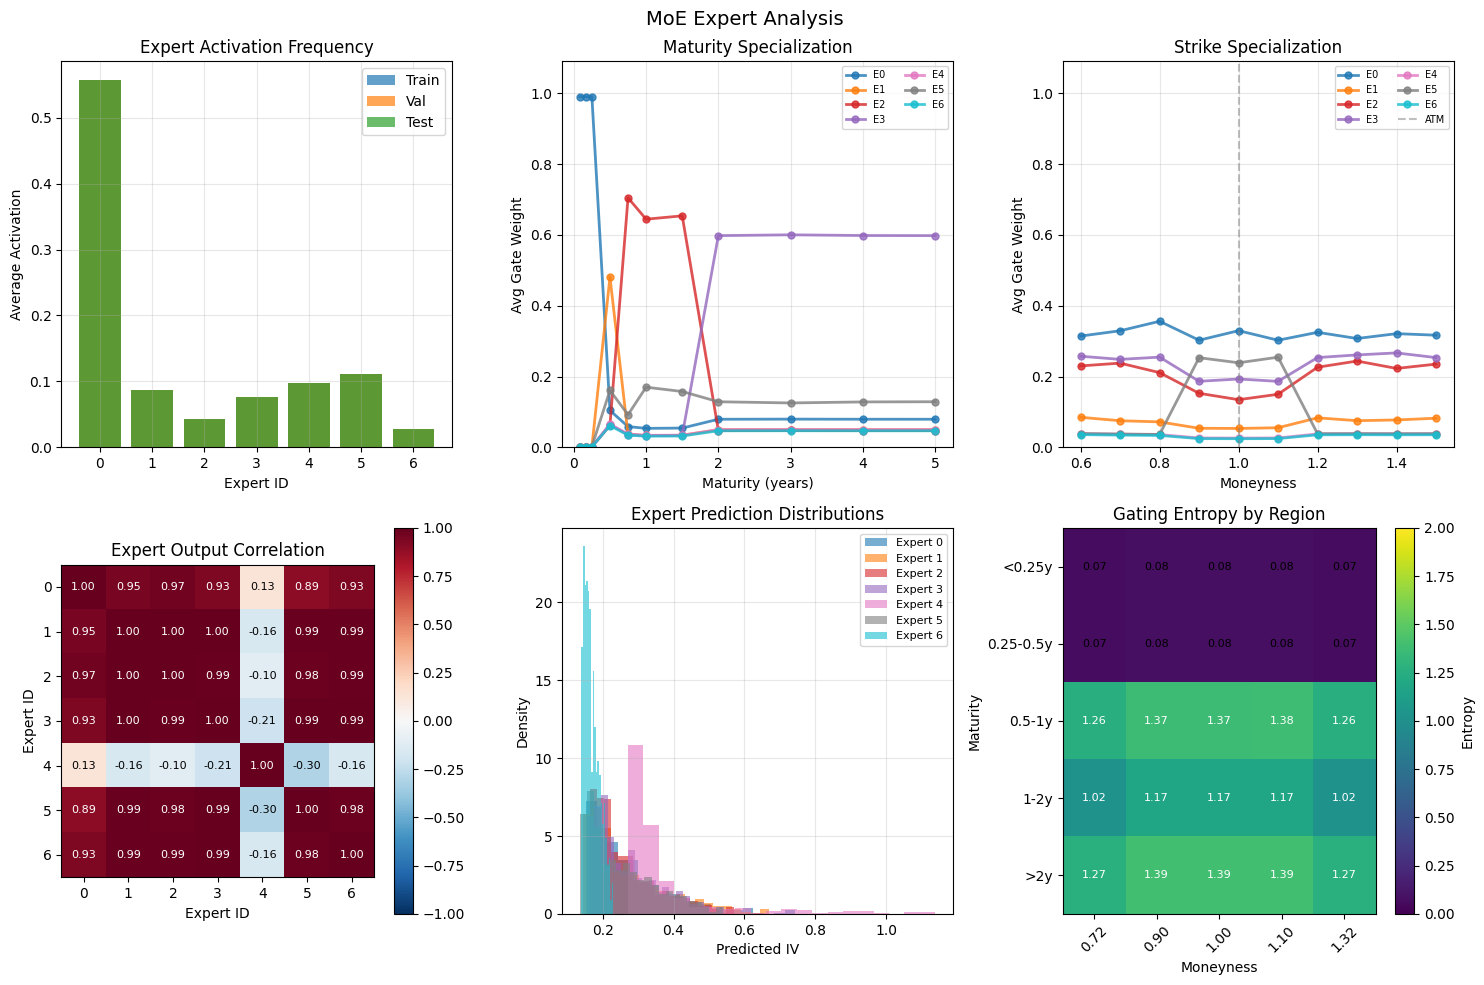


Summary:
Most active expert: 0
Least active expert: 6
Balance score: 0.829
Avg entropy: 1.440
Min correlation: -0.302
Max correlation: 1.000


In [27]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod_2,    # moe decoder
   X_train,           # training inputs [z+f, strikes, taus]
   X_val,             # validation inputs
   X_test,            # test inputs  
   y_train,           # training targets
   y_val,             # validation targets
   y_test             # test targets
)

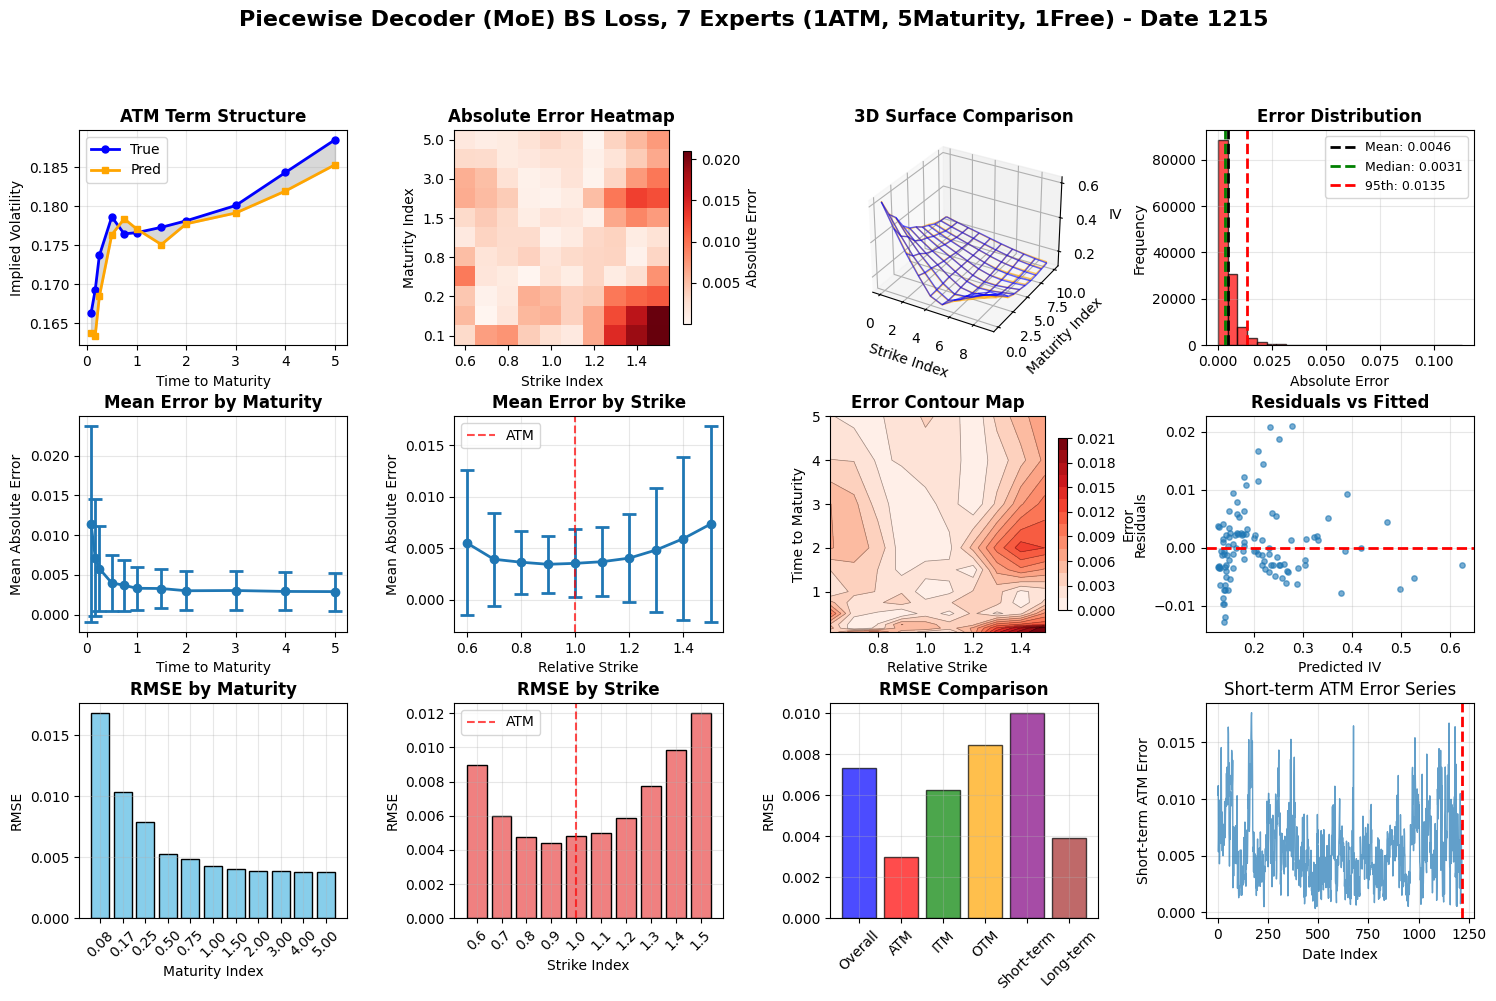

Overall Performance Category Performance  \
RMSE                           0.007352                  NaN   
MAE                            0.004581                  NaN   
Max Error                      0.112924                  NaN   
Mean Error                     0.004581                  NaN   
Median Error                   0.003090                  NaN   
95th Percentile                0.013453                  NaN   
ATM RMSE                            NaN             0.003007   
ITM RMSE                            NaN             0.006280   
OTM RMSE                            NaN             0.008479   
Short-term RMSE                     NaN             0.010016   
Long-term RMSE                      NaN             0.003937   
Short/Long Ratio                    NaN                2.544   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.003751)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.016786)                       NaN  
Best Strike           K=0.9 (RMSE: 0.004414)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.012000)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.004823)                       NaN  
Overall Rank              ATM ranks #7 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.544)  
ATM Issues                               NaN   NO (ATM/Overall: 0.41x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.002199)  
High Error Variance                      NaN       YES (std: 0.005750)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [28]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prep strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_2.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,
  Y_pred=Y_hat,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title="Piecewise Decoder (MoE) BS Loss, 7 Experts (1ATM, 5Maturity, 1Free)"
)

In [29]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe_2 = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name=name,
   model=decoder_pw_mod_2
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   summary_pw_moe_2
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0   piecewise moe v2 - 7exp (4mat/2free) relu div0.3     1     0.007352   
1  Piecewise Decoder with BS Loss (MoE) 7 Experts...     2     0.007599   
2              Piecewise Decoder with BS Loss-FW-PCA     3     0.010190   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.004581  0.004823  0.003522  0.006280  0.008479         2.544206   
1    0.005074  0.005752  0.003913  0.006467  0.008684         2.368279   
2    0.006868  0.011014  0.006970  0.009147  0.010793         2.921050   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.112924             True       False     EXCELLENT             False  
1  0.084807             True       False     EXCELLENT             False  
2  0.078045             True       False          GOOD             False

####  Experiment 3

Training MoE Modular Decoder
Expert allocation: ATM=0, Maturity=0, Free=4, Total=4
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - loss: 2.9980 - val_loss: 0.3113 - learning_rate: 1.0000e-04
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - loss: 0.1987 - val_loss: 0.0763 - learning_rate: 1.0000e-04
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - loss: 0.0561 - val_loss: 0.0416 - learning_rate: 1.0000e-04
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - loss: 0.0328 - val_loss: 0.0319 - learning_rate: 1.0000e-04
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - loss: 0.0244 - val_loss: 0.0241 - learning_rate: 1.0000e-04
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - loss: 0.0195 - val_loss: 0.0202 - learning_rate: 1.0000e-04
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 63s 22ms/step - loss: 0.0159 - val_loss: 0.0183 - learning_rate: 1.0000e-04
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - loss: 0.0131 - val_loss: 

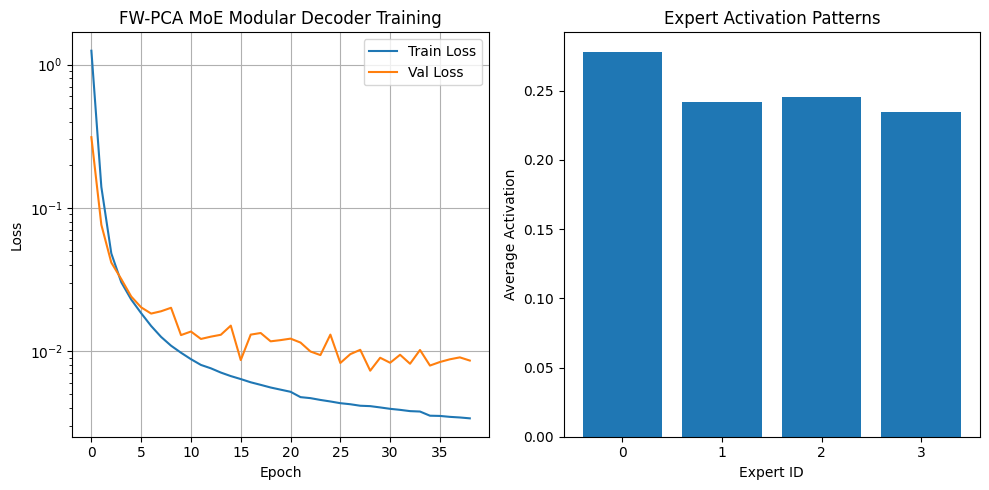

In [30]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

USE_MOE = True

print(f"Training {'MoE' if USE_MOE else 'Standard'} Modular Decoder")

decoder_pw_mod_3 = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_moe=True,
   num_experts=4,                    
   
   maturity_experts=4,               
   free_experts=0,                   
   maturity_specialization=False,
   
   atm_specialization=False,         
   atm_loss_weight=1.0,
   
   lambda_diversity=0.25,
)

decoder_pw_mod_3.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/fwpca/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/fwpca/piecewise_surface_mod_{model_suffix}_3/decoder_fwpca.keras", save_best_only=True, verbose=0)
]

history = decoder_pw_mod_3.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"FW-PCA {'MoE' if USE_MOE else 'Standard'} Modular Decoder Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   analysis = decoder_pw_mod_3.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod_3.num_experts), analysis['expert_activations'])
       plt.title("Expert Activation Patterns")
       plt.xlabel("Expert ID")
       plt.ylabel("Average Activation")
       plt.xticks(range(decoder_pw_mod_3.num_experts))
       
       print(f"\nExpert Analysis:")
       print(f"  Expert activations: {analysis['expert_activations']}")
       print(f"  Average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
 exp 3 , only maturity, 4 Experts, atm 0, 0 Free RMSE_σ: 0.0065
RMSE by maturity (mean ± std): 0.0068 ± 0.0037
RMSE by strike    (mean ± std): 0.0074 ± 0.0023
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


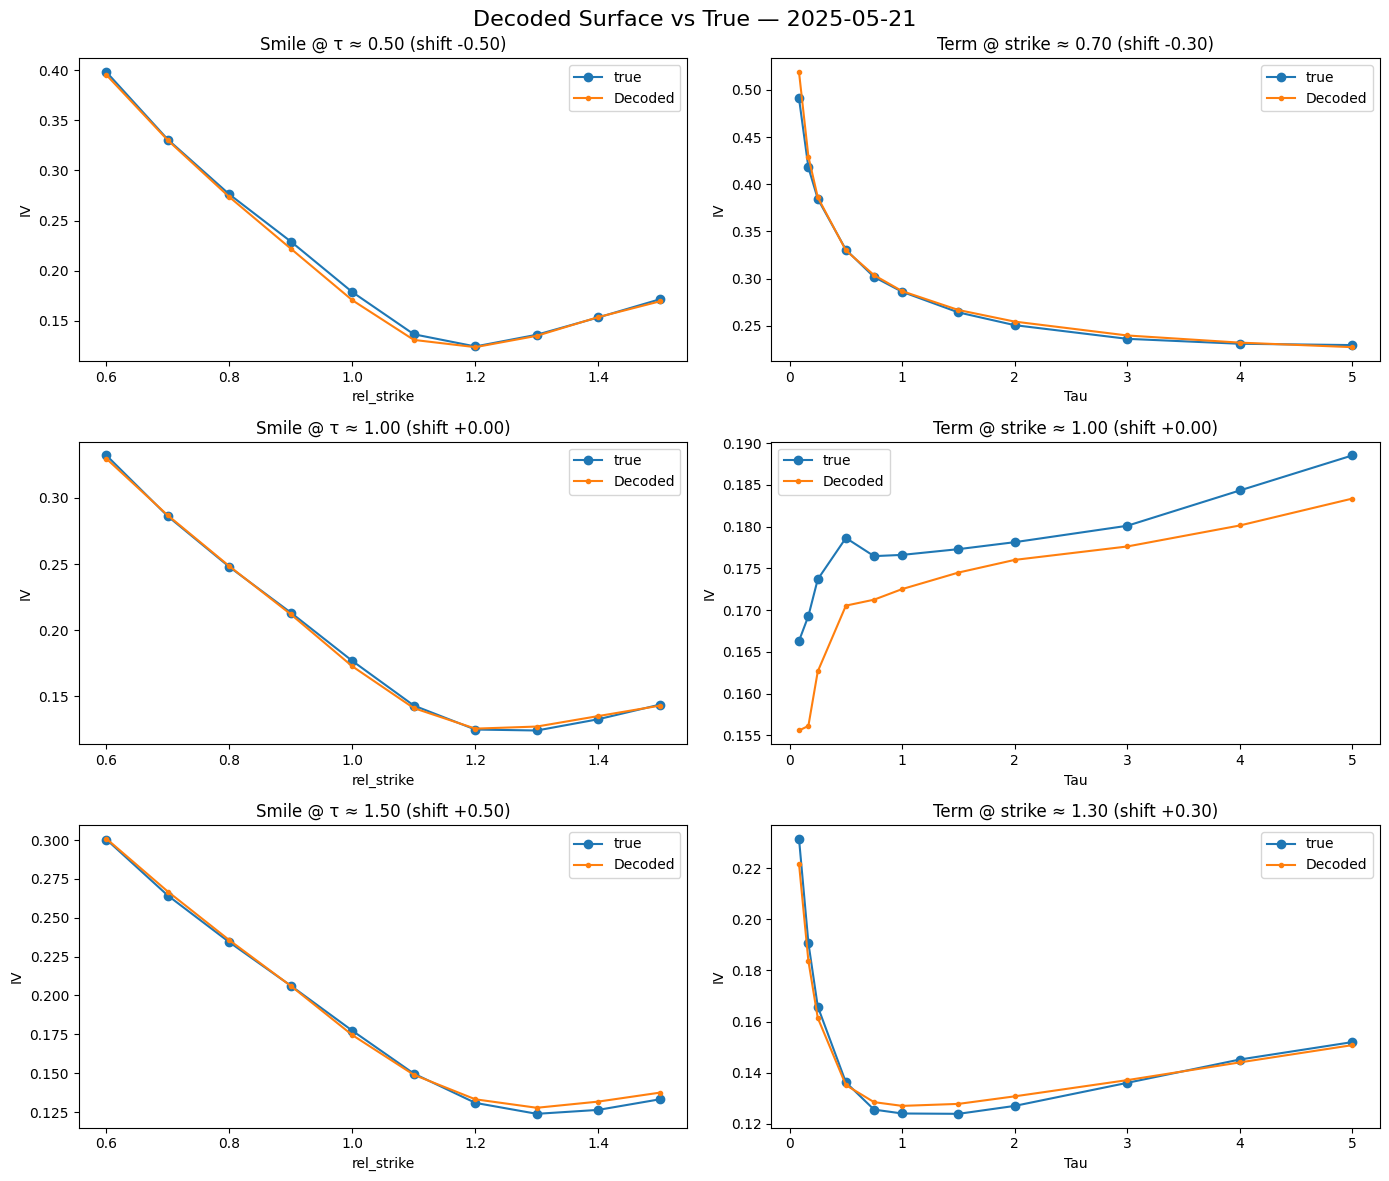

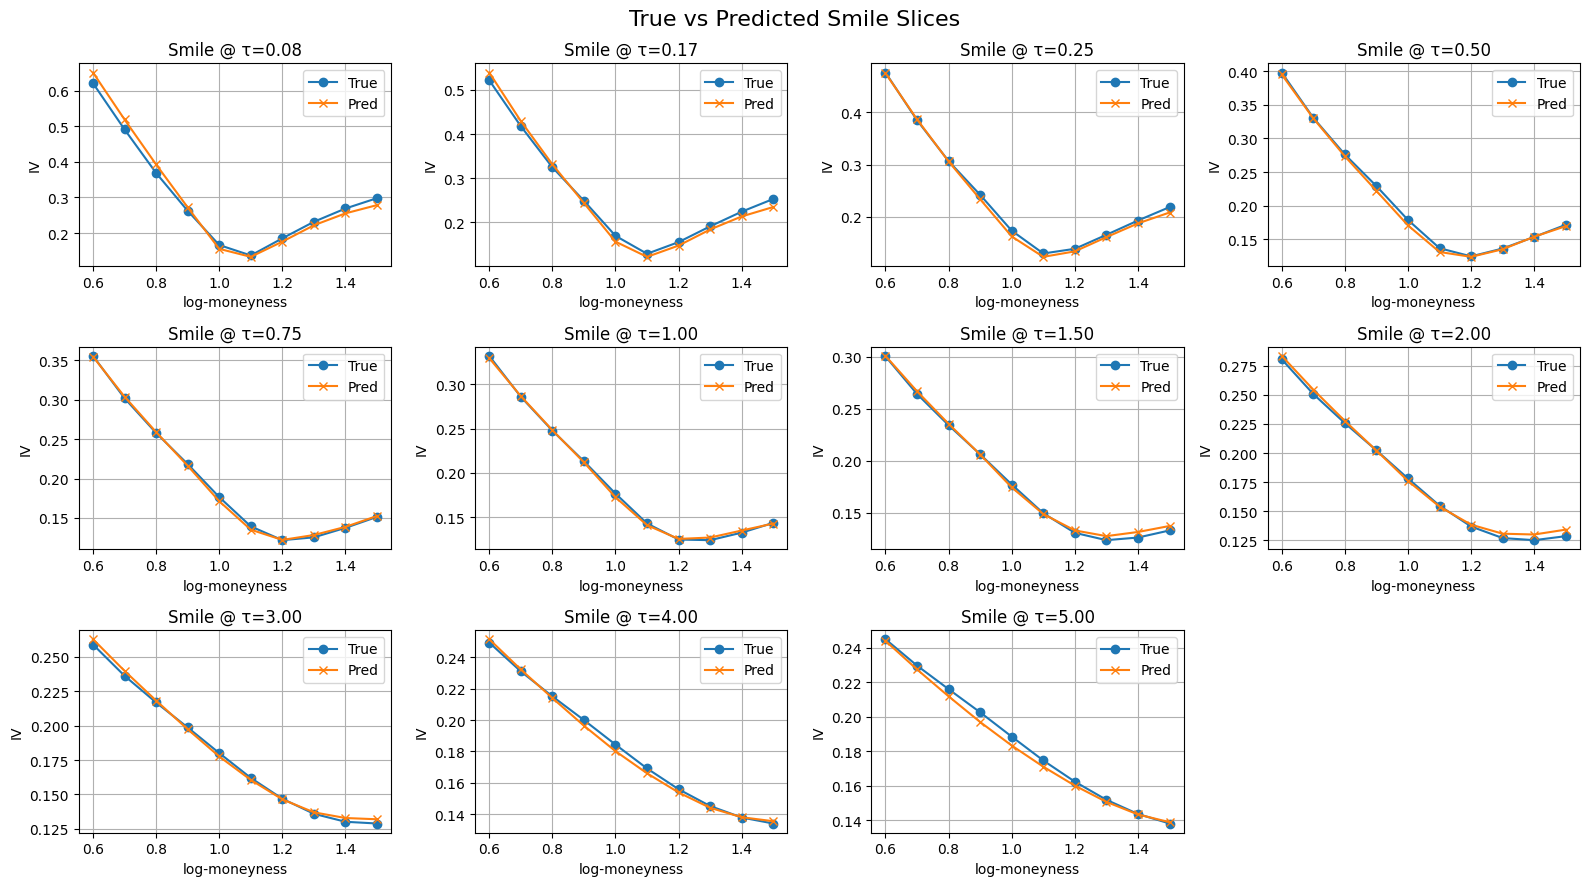

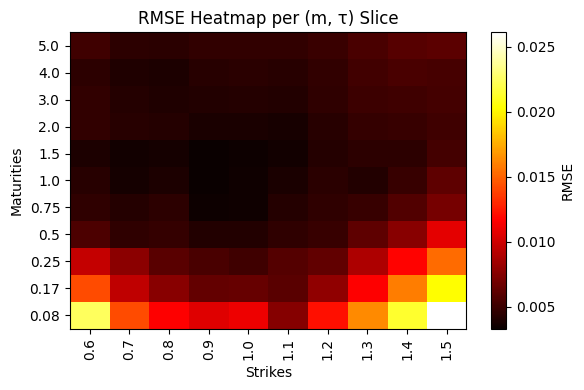

{'rmse_overall': 0.006506856,
 'rmse_by_maturity': array([0.01638248, 0.0115395 , 0.00877025, 0.00606249, 0.00479326,
        0.00431258, 0.00408141, 0.00442877, 0.0046045 , 0.00468364,
        0.00510339], dtype=float32),
 'rmse_by_strike': array([0.00941235, 0.00668998, 0.00581925, 0.00528509, 0.00541177,
        0.00493778, 0.00617796, 0.00791033, 0.00999462, 0.01235291],
       dtype=float32)}

In [31]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

name = " exp 3 , only maturity, 4 Experts, atm 0, 0 Free"

# --- Eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) - flattened ground truth

# --- Prepare strike–tau grid
m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# --- Generate predictions
Y_hat = np.stack([
   decoder_pw_mod_3.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")

# --- Evaluate using new function
evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # Pre-computed predictions (N, M, K)
    Y_true=Y_full,                         # Ground truth (N, M*K) - auto-reshaped
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod,                    # For penalty calculation
    title=name
)



MoE Analysis
Experts: 4
Diversity: 0.25


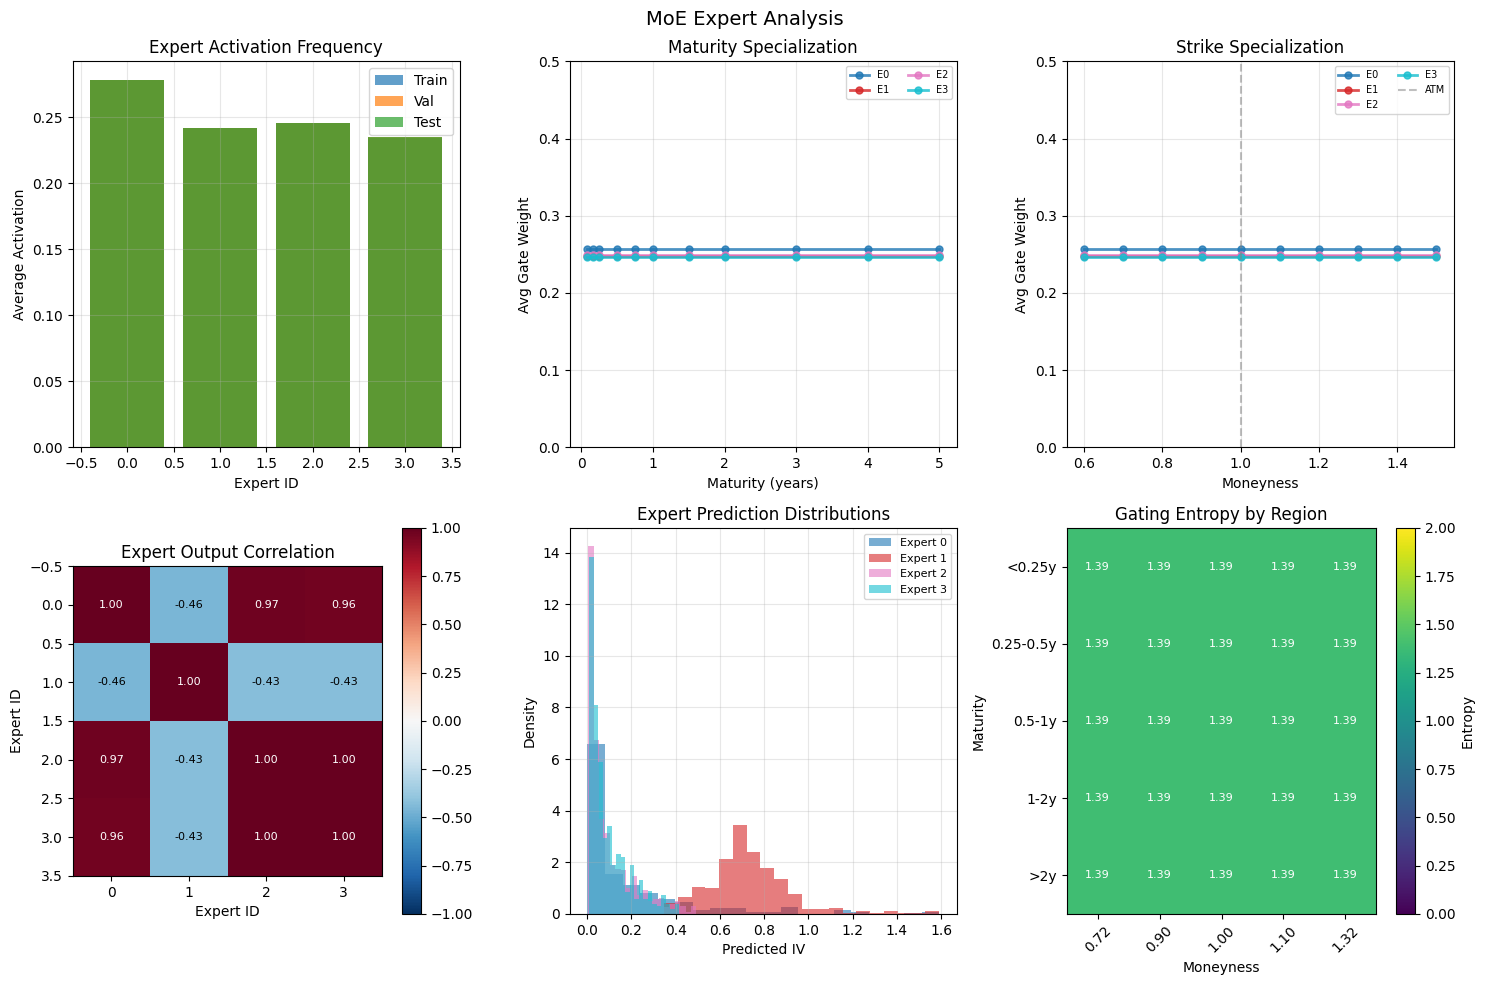


Summary:
Most active expert: 0
Least active expert: 3
Balance score: 0.983
Avg entropy: 1.384
Min correlation: -0.458
Max correlation: 1.000


In [32]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance


results = analyze_moe_training_performance(
   decoder_pw_mod_3,
   X_train,
   X_val,
   X_test,
   y_train,
   y_val,
   y_test
)

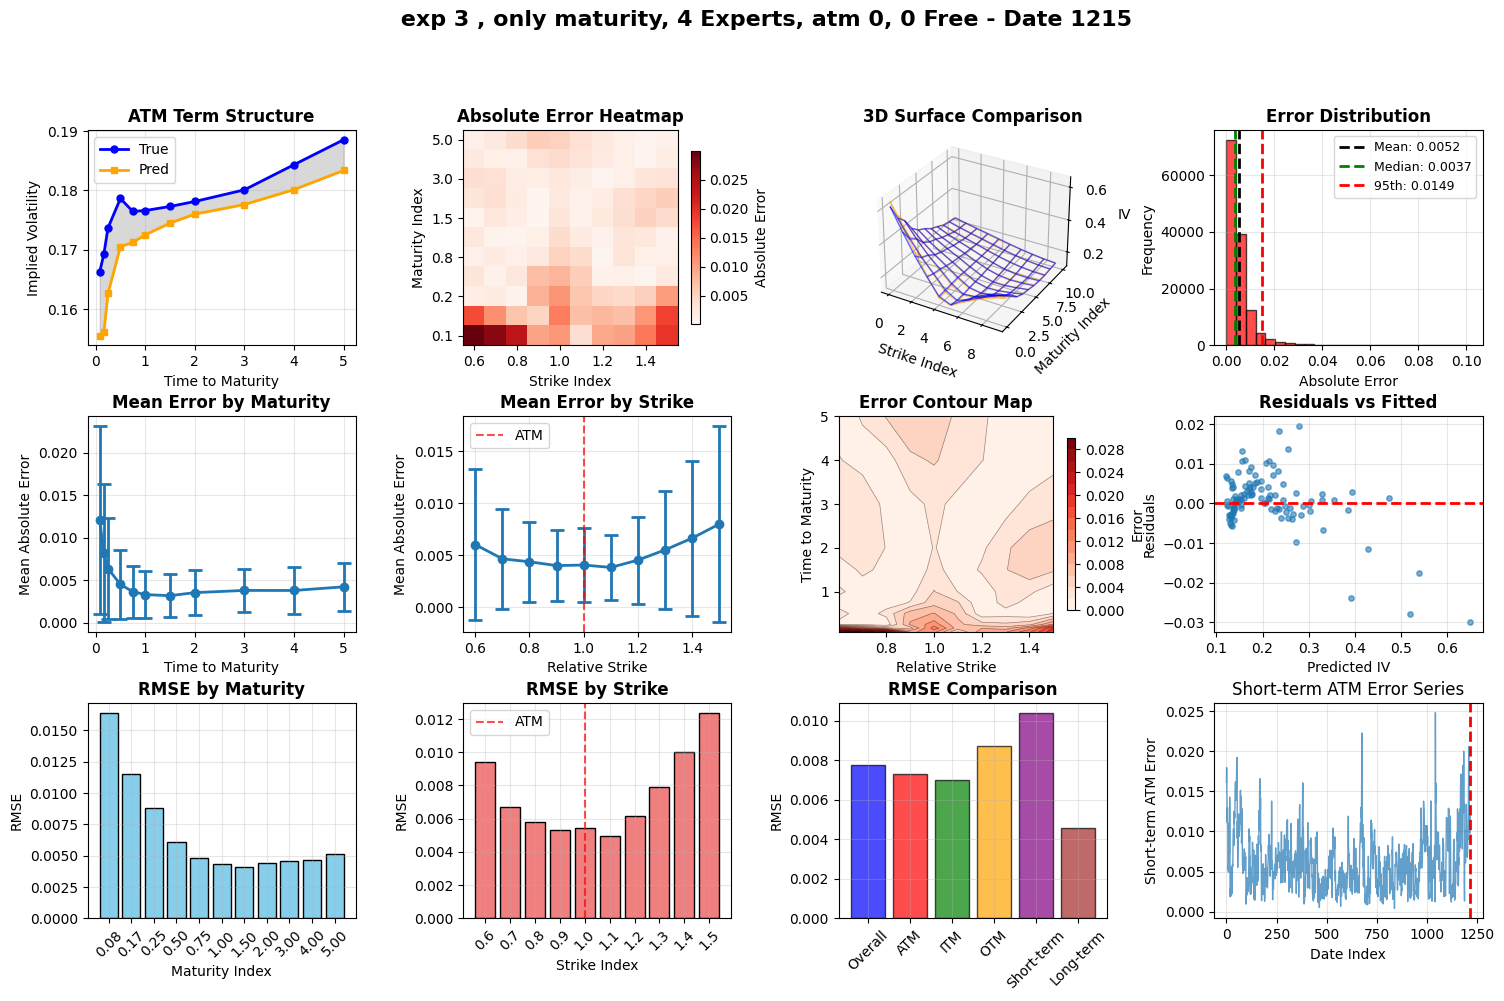

Overall Performance Category Performance  \
RMSE                           0.007759                  NaN   
MAE                            0.005172                  NaN   
Max Error                      0.101765                  NaN   
Mean Error                     0.005172                  NaN   
Median Error                   0.003712                  NaN   
95th Percentile                0.014932                  NaN   
ATM RMSE                            NaN             0.007278   
ITM RMSE                            NaN             0.006985   
OTM RMSE                            NaN             0.008690   
Short-term RMSE                     NaN             0.010375   
Long-term RMSE                      NaN             0.004547   
Short/Long Ratio                    NaN                2.282   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=1.50 (RMSE: 0.004081)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.016382)                       NaN  
Best Strike           K=1.1 (RMSE: 0.004938)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.012353)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.005412)                       NaN  
Overall Rank              ATM ranks #7 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.282)  
ATM Issues                               NaN   NO (ATM/Overall: 0.94x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001706)  
High Error Variance                      NaN       YES (std: 0.005784)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [33]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike tau grid
m_grid, tau_grid = np.meshgrid(
    ops.convert_to_numpy(tensors["strike_tensor"]),
    ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
    decoder_pw_mod_3.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match predictions
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run comprehensive analysis
metrics = analyze_decoder_comprehensive(
    Y_true=Y_full,              # ground truth surfaces reshaped
    Y_pred=Y_hat,               # predicted surfaces from piecewise decoder
    taus=ops.convert_to_numpy(tensors["taus"]),
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    date_idx=-1,                # last date
    dates=None,                 # optional date list for labeling
    title=name
)

In [34]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe_3 = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name=name,
   model=decoder_pw_mod_3
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   summary_pw_moe_2,
   summary_pw_moe_3
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0   piecewise moe v2 - 7exp (4mat/2free) relu div0.3     1     0.007352   
1  Piecewise Decoder with BS Loss (MoE) 7 Experts...     2     0.007599   
2    exp 3 , only maturity, 4 Experts, atm 0, 0 Free     3     0.007759   
3              Piecewise Decoder with BS Loss-FW-PCA     4     0.010190   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.004581  0.004823  0.003522  0.006280  0.008479         2.544206   
1    0.005074  0.005752  0.003913  0.006467  0.008684         2.368279   
2    0.005172  0.005412  0.004069  0.006985  0.008690         2.281686   
3    0.006868  0.011014  0.006970  0.009147  0.010793         2.921050   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.112924             True       False     EXCELLENT             False  
1  0.084807             True       False     EXCELLENT             False  
2  0.101765             True       False     EXCELLENT             False  
3  0.078045             True       False          GOOD             False

### Experiment 4 

Training MoE Modular Decoder
Expert allocation: ATM=0, Maturity=0, Free=3, Total=3
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 9.7960 - val_loss: 1.5386 - learning_rate: 1.0000e-05
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 94s 32ms/step - loss: 1.4157 - val_loss: 1.2028 - learning_rate: 1.0000e-05
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 92s 32ms/step - loss: 1.0989 - val_loss: 0.9566 - learning_rate: 1.0000e-05
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 109s 37ms/step - loss: 0.8582 - val_loss: 0.7554 - learning_rate: 1.0000e-05
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 116s 40ms/step - loss: 0.6610 - val_loss: 0.5864 - learning_rate: 1.0000e-05
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 118s 40ms/step - loss: 0.5003 - val_loss: 0.4514 - learning_rate: 1.0000e-05
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 132s 45ms/step - loss: 0.3866 - val_loss: 0.3469 - learning_rate: 1.0000e-05
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 95s 32ms/step - loss: 0.3066 - val_lo

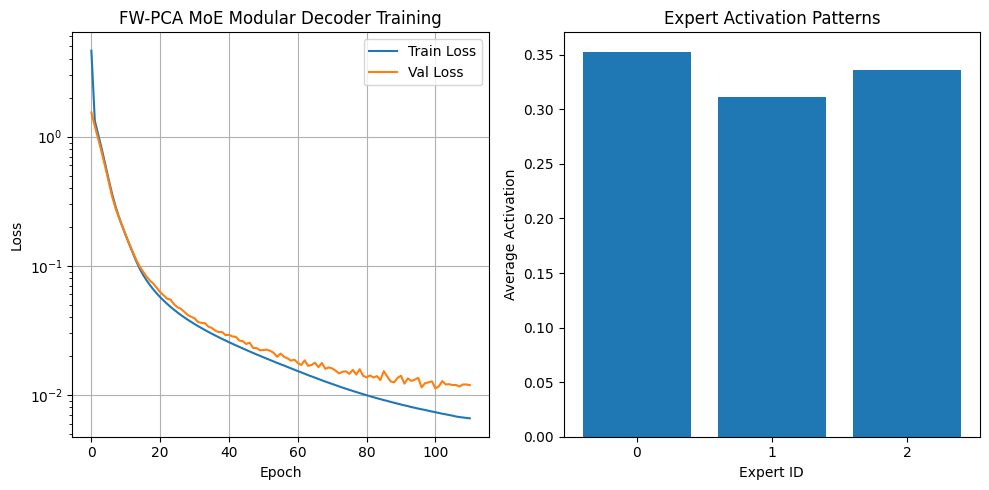

In [35]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

USE_MOE = True

print(f"Training {'MoE' if USE_MOE else 'Standard'} Modular Decoder")

decoder_pw_mod_4 = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_moe=True,
   num_experts=3,                    
   
   maturity_experts=0,               
   free_experts=3,                   
   maturity_specialization=False,
   
   atm_specialization=False,         
   atm_loss_weight=1.0,
   
   lambda_diversity=0.5,
)

decoder_pw_mod_4.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=hybrid_loss_fn)

model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/piecewise_surface_mod_{model_suffix}_4/decoder_fwpca.keras", save_best_only=True, verbose=0)
]

history = decoder_pw_mod_4.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"FW-PCA {'MoE' if USE_MOE else 'Standard'} Modular Decoder Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   analysis = decoder_pw_mod_4.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod_4.num_experts), analysis['expert_activations'])
       plt.title("Expert Activation Patterns")
       plt.xlabel("Expert ID")
       plt.ylabel("Average Activation")
       plt.xticks(range(decoder_pw_mod_4.num_experts))
       
       print(f"\nExpert Analysis:")
       print(f"  Expert activations: {analysis['expert_activations']}")
       print(f"  Average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

y_hat shape: (1216, 11, 10)
y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
Piecewise Decoder with BS Loss, Moe 3 Experts (0ATM, 0Maturity, 3Free) RMSE_σ: 0.0066
RMSE by maturity (mean ± std): 0.0069 ± 0.0042
RMSE by strike    (mean ± std): 0.0077 ± 0.0023
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


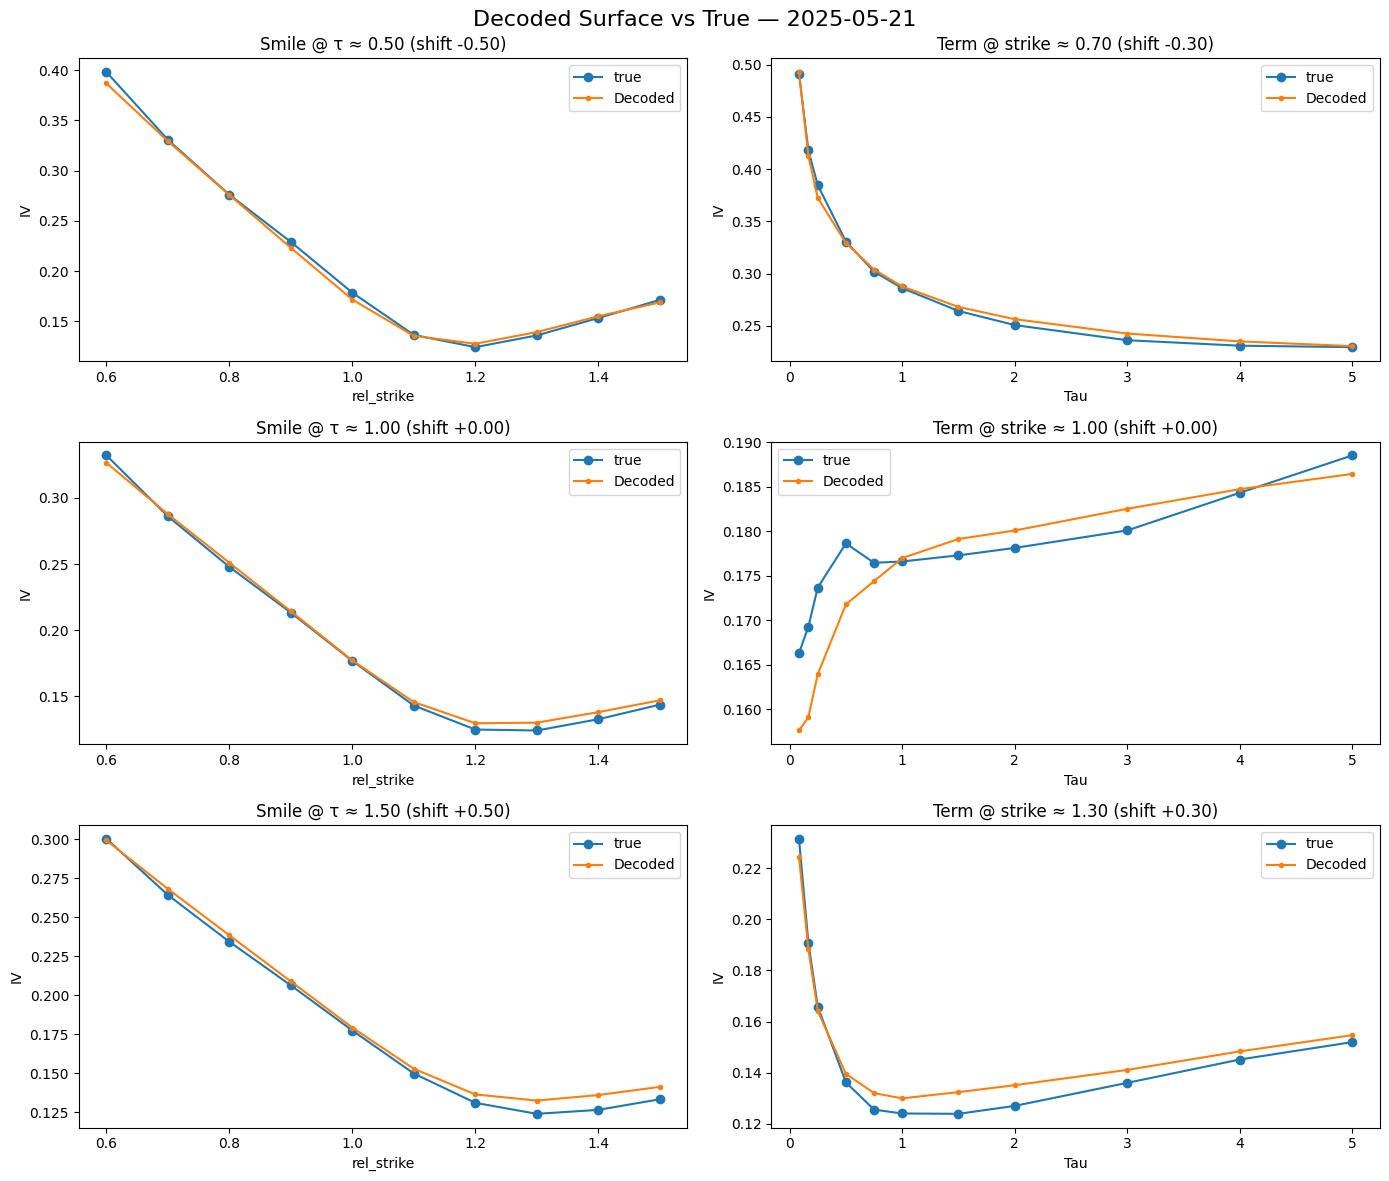

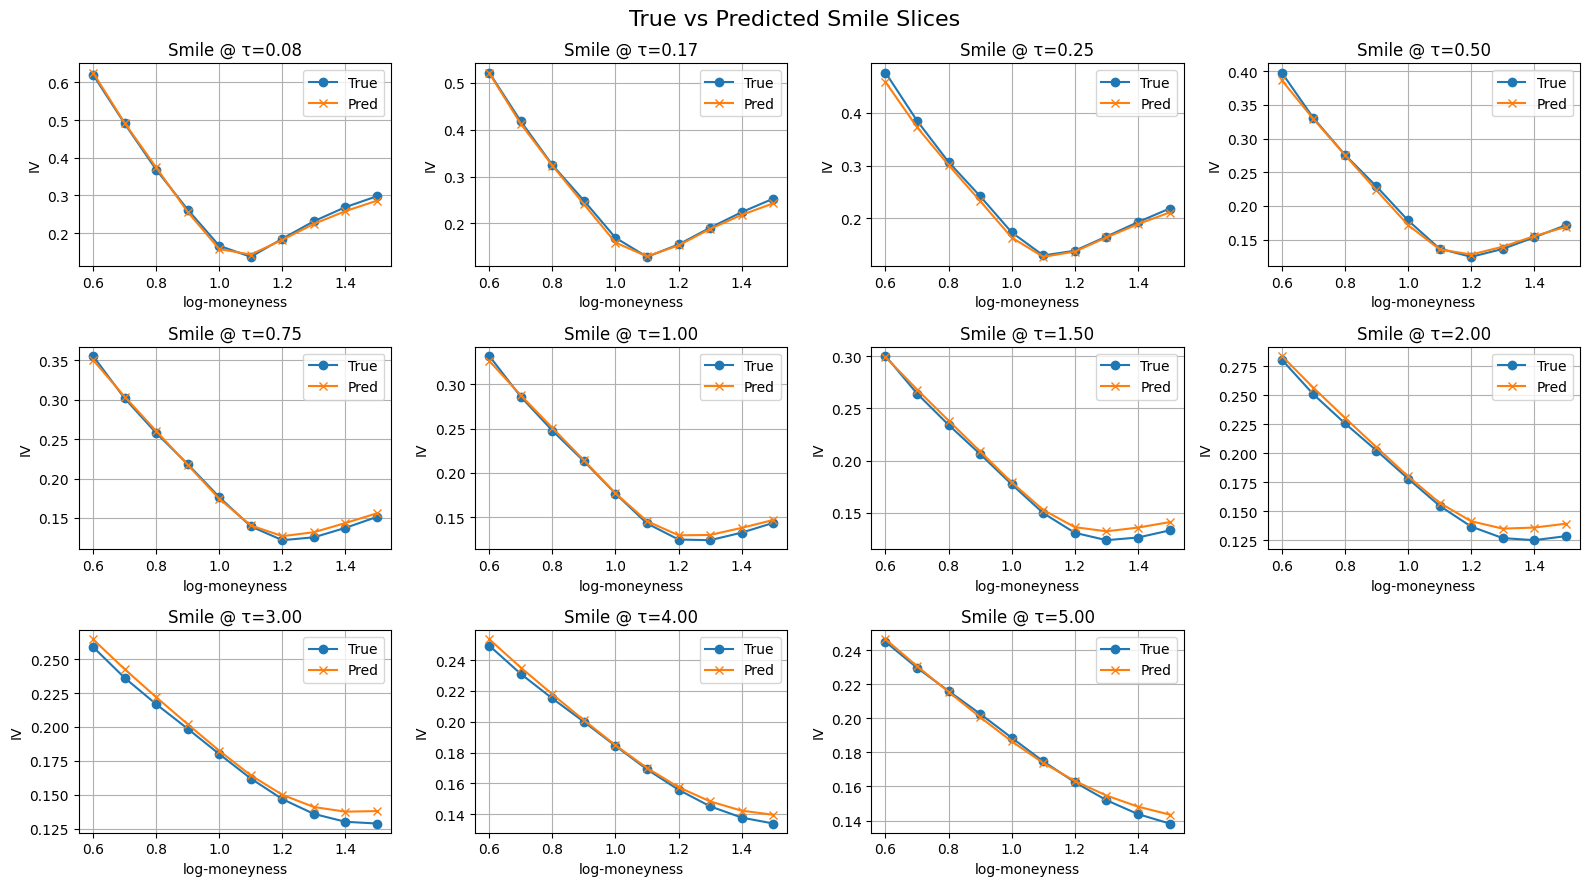

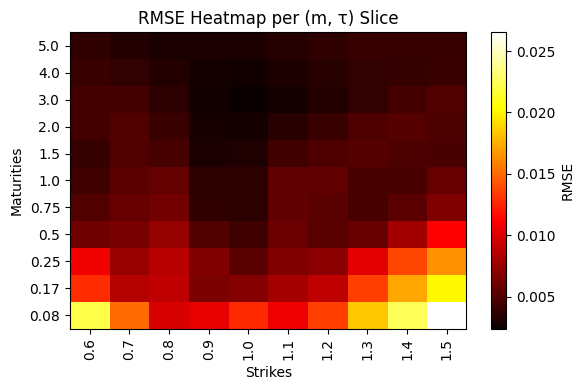

MoE Analysis
Experts: 3
Diversity: 0.5


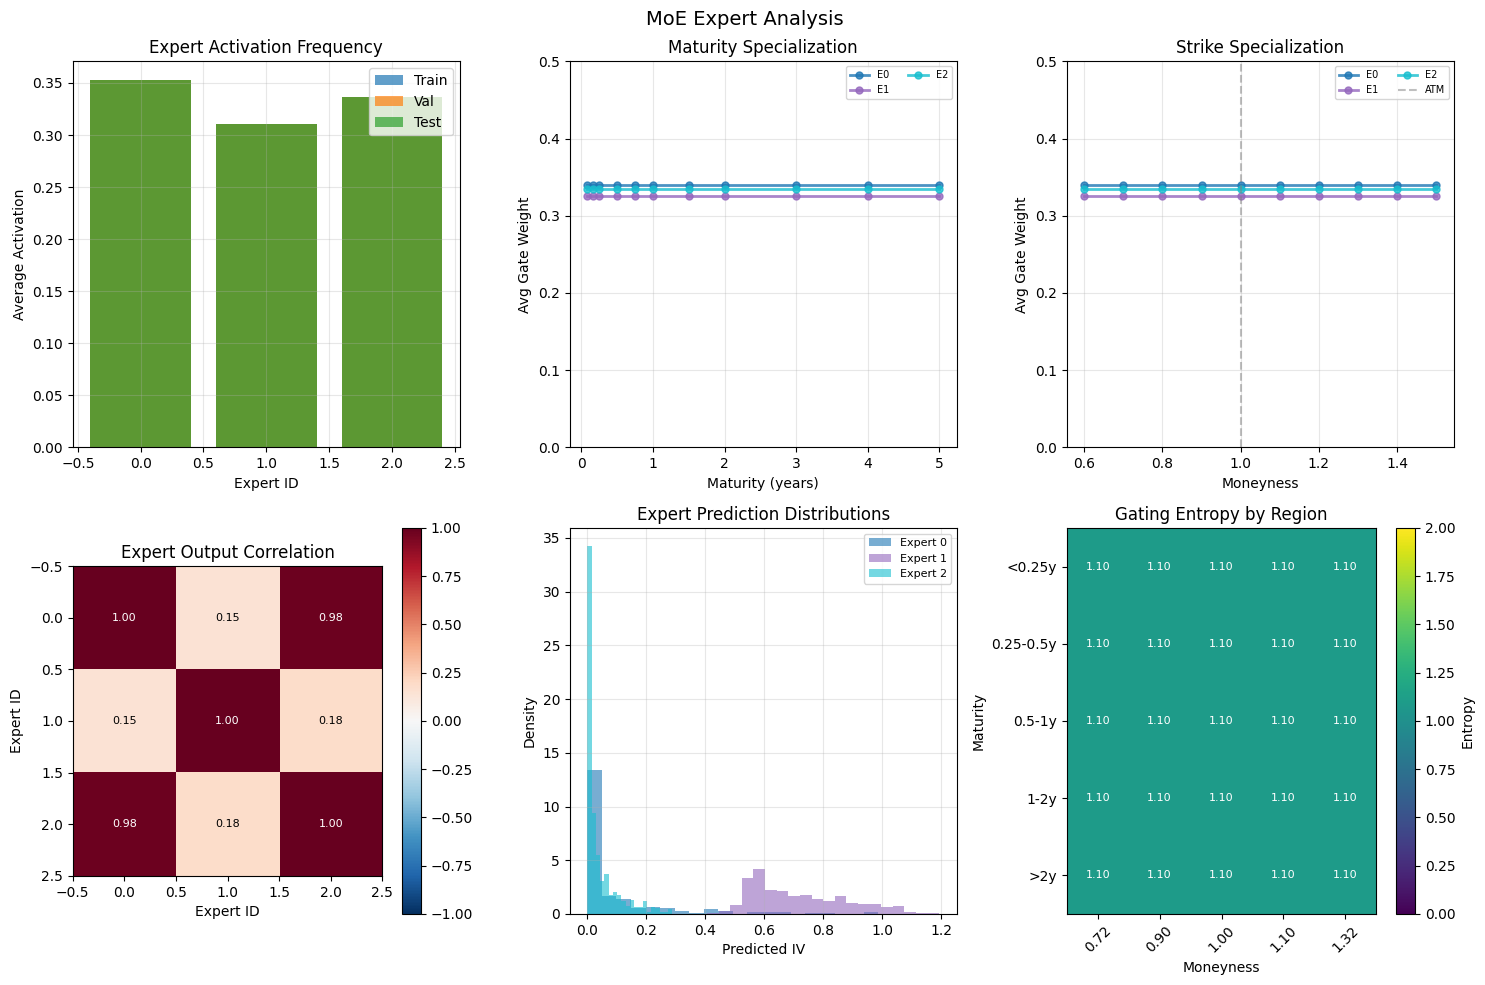


Summary:
Most active expert: 0
Least active expert: 1
Balance score: 0.983
Avg entropy: 1.097
Min correlation: 0.145
Max correlation: 1.000


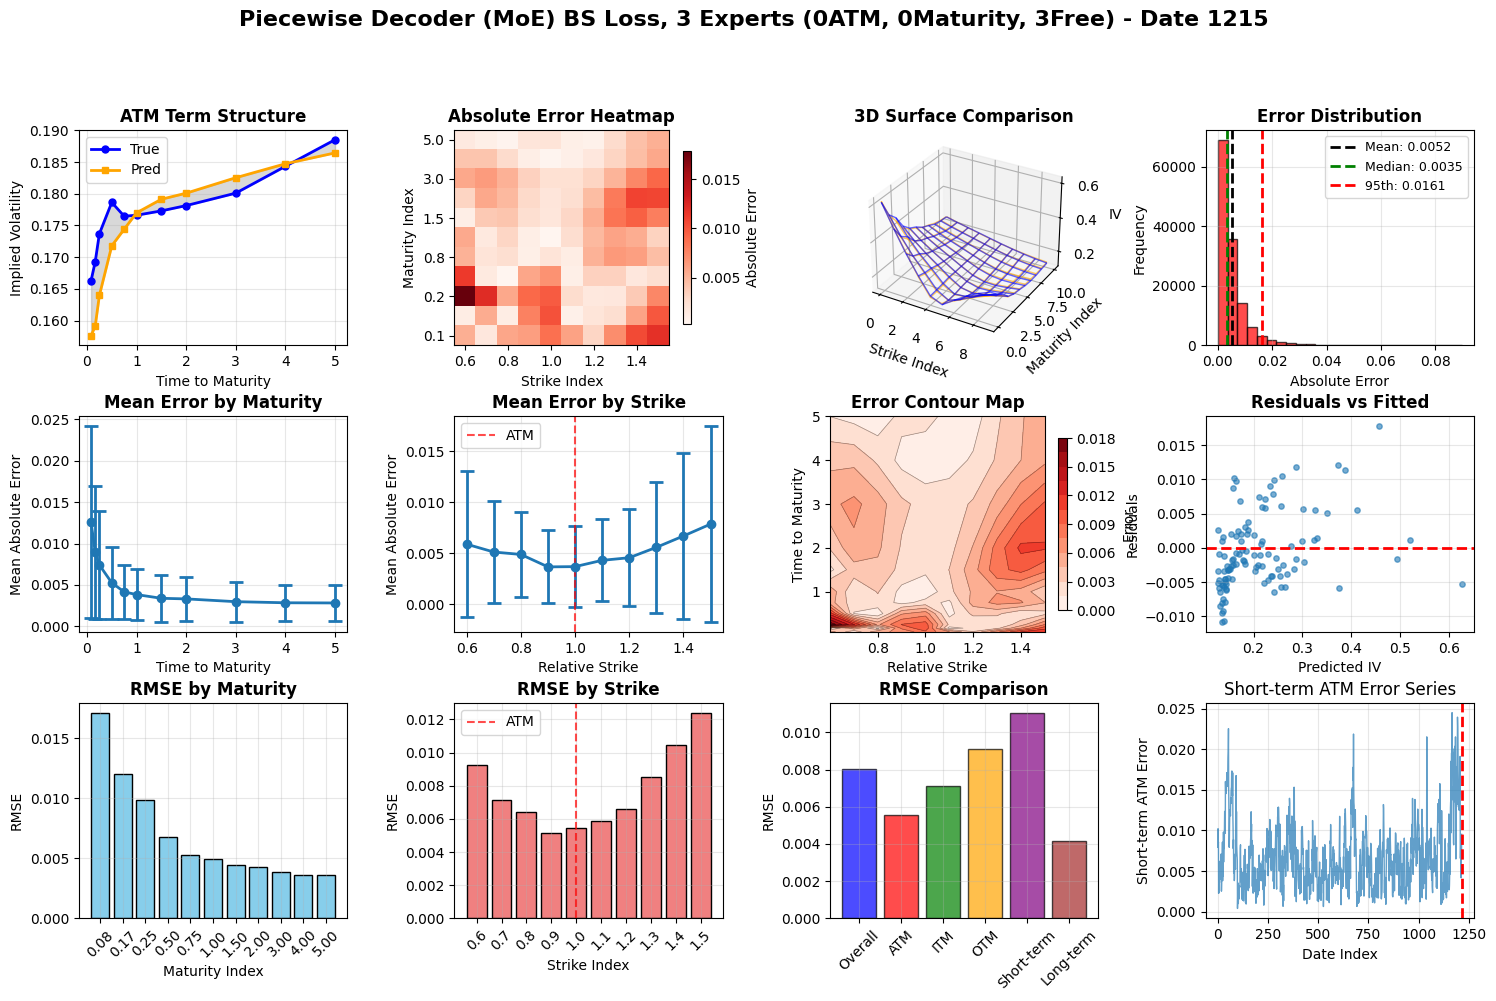

Overall Performance Category Performance  \
RMSE                           0.008040                  NaN   
MAE                            0.005221                  NaN   
Max Error                      0.089715                  NaN   
Mean Error                     0.005221                  NaN   
Median Error                   0.003455                  NaN   
95th Percentile                0.016146                  NaN   
ATM RMSE                            NaN             0.005577   
ITM RMSE                            NaN             0.007136   
OTM RMSE                            NaN             0.009093   
Short-term RMSE                     NaN             0.011032   
Long-term RMSE                      NaN             0.004135   
Short/Long Ratio                    NaN                2.668   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.003575)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.017109)                       NaN  
Best Strike           K=0.9 (RMSE: 0.005120)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.012381)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.005418)                       NaN  
Overall Rank              ATM ranks #7 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.668)  
ATM Issues                               NaN   NO (ATM/Overall: 0.69x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001958)  
High Error Variance                      NaN       YES (std: 0.006114)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [36]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prep strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_4.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

print(f"y_hat shape: {Y_hat.shape}")
print(f"y_full shape: {Y_full.shape}")

# evaluate
evaluate_decoder_output_v2(
   Y_pred=Y_hat,
   Y_true=Y_full,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw_mod_4,
   title="Piecewise Decoder with BS Loss, Moe 3 Experts (0ATM, 0Maturity, 3Free)"
)

import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod_4,
   X_train,
   X_val,
   X_test,
   y_train,
   y_val,
   y_test
)

import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config again
Z_eval = Z_decoder
F_eval = F_aligned
Y_full = Y_decoder

# prep grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_4.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,
  Y_pred=Y_hat,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title="Piecewise Decoder (MoE) BS Loss, 3 Experts (0ATM, 0Maturity, 3Free)"
)

In [37]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

name = " ex 4 , 7 Experts, atm 1, 2 Free, 4 Maturity"

summary_pw_moe_4 = summarize_decoder_errors(
    Y_true=Y_full, 
    Y_pred=Y_hat,
    taus=taus, 
    rel_strikes=rel_strikes,
    name= name,
    model=decoder_pw_mod_4
)

 
summary_all_decoders = collect_decoder_summaries(
    summary_pw_decoder,
    summary_pw_moe,
    summary_pw_moe_2,
    summary_pw_moe_3,
    summary_pw_moe_4
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0   piecewise moe v2 - 7exp (4mat/2free) relu div0.3     1     0.007352   
1  Piecewise Decoder with BS Loss (MoE) 7 Experts...     2     0.007599   
2    exp 3 , only maturity, 4 Experts, atm 0, 0 Free     3     0.007759   
3        ex 4 , 7 Experts, atm 1, 2 Free, 4 Maturity     4     0.008040   
4              Piecewise Decoder with BS Loss-FW-PCA     5     0.010190   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.004581  0.004823  0.003522  0.006280  0.008479         2.544206   
1    0.005074  0.005752  0.003913  0.006467  0.008684         2.368279   
2    0.005172  0.005412  0.004069  0.006985  0.008690         2.281686   
3    0.005221  0.005418  0.003690  0.007136  0.009093         2.668121   
4    0.006868  0.011014  0.006970  0.009147  0.010793         2.921050   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.112924             True       False     EXCELLENT             False  
1  0.084807             True       False     EXCELLENT             False  
2  0.101765             True       False     EXCELLENT             False  
3  0.089715             True       False     EXCELLENT             False  
4  0.078045             True       False          GOOD             False

---
---

## SHALLOW DECODER

---
---

---
---

## Residual correction to address post specific bias from full decoder

---
---

In [38]:
print(f"dimension checks:")
print(f"M*K = {M*K}")
print(f"Z_train shape: {Z_train.shape}")
print(f"F_train shape: {F_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

# need fwpca baseline predictions first
fwpca_train_pred = decoder.predict(Z_train)[:, :M*K]  # surface only
fwpca_val_pred = decoder.predict(Z_val)[:, :M*K]
fwpca_test_pred = decoder.predict(Z_test)[:, :M*K]

print(f"fwpca predictions shape: {fwpca_train_pred.shape}")

# convert fwpca baseline to pointwise format
[_, _, _], fwpca_train_pointwise = decoder_pw.build_training_data_from_surfaces(
   Z_train, fwpca_train_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_train
)
[_, _, _], fwpca_val_pointwise = decoder_pw.build_training_data_from_surfaces(
   Z_val, fwpca_val_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_val
)
[_, _, _], fwpca_test_pointwise = decoder_pw.build_training_data_from_surfaces(
   Z_test, fwpca_test_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_test
)

print(f"fwpca pointwise shape: {fwpca_train_pointwise.shape}")

# compute residual targets (y_true - fwpca_baseline)
Y_residual_train = y_train - fwpca_train_pointwise
Y_residual_val = y_val - fwpca_val_pointwise
Y_residual_test = y_test - fwpca_test_pointwise

print(f"\nresidual statistics:")
print(f"train residuals - mean: {Y_residual_train.mean():.6f}, std: {Y_residual_train.std():.6f}")
print(f"train residuals - range: [{Y_residual_train.min():.6f}, {Y_residual_train.max():.6f}]")
print(f"val residuals - mean: {Y_residual_val.mean():.6f}, std: {Y_residual_val.std():.6f}")
print(f"val residuals - range: [{Y_residual_val.min():.6f}, {Y_residual_val.max():.6f}]")
print(f"test residuals - mean: {Y_residual_test.mean():.6f}, std: {Y_residual_test.std():.6f}")
print(f"test residuals - range: [{Y_residual_test.min():.6f}, {Y_residual_test.max():.6f}]")

# setup single experiment - mlp residual correction with features
Y_rl_train = Y_residual_train
Y_rl_val = Y_residual_val
Y_rl_test = Y_residual_test
X_rl_train = X_train  # [z+f, grid] with features
X_rl_val = X_val
X_rl_test = X_test

print(f"\nexperiment setup:")
print(f"mlp residual correction with features:")
print(f"input x: {len(X_rl_train)} arrays, shapes: {[x.shape for x in X_rl_train]}")
print(f"target y: {Y_rl_train.shape}")

dimension checks:
M*K = 110
Z_train shape: (851, 12)
F_train shape: (851, 136)
Y_train shape: (851, 110)
fwpca predictions shape: (851, 110)
fwpca pointwise shape: (93610, 1)

residual statistics:
train residuals - mean: -0.001862, std: 0.020179
train residuals - range: [-0.149267, 0.165611]
val residuals - mean: 0.001247, std: 0.014517
val residuals - range: [-0.108530, 0.272248]
test residuals - mean: 0.002030, std: 0.025235
test residuals - range: [-0.307347, 0.268250]

experiment setup:
mlp residual correction with features:
input x: 3 arrays, shapes: [(93610, 148), (93610, 1), (93610, 1)]
target y: (93610, 1)


In [39]:
import models.rl_decoder
import importlib    
importlib.reload(models.rl_decoder)

from models.rl_decoder import PointwiseRLDecoder
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam



# Setup model

rl_model = PointwiseRLDecoder(
    use_delta=False,
    normalize_delta=False,
    correction_scale=1.0,
    use_bs_loss=True,
    taus=ops.convert_to_numpy(tensors["taus"]),
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    M=M,
    K=K
)
rl_model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0))

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-6),
    ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
    ModelCheckpoint("saved_models/rl_decoder/pointwise_rl_residual_fwpca.keras", save_best_only=True, verbose=0)
]

# Train
history = rl_model.fit(
    x=X_rl_train,
    y=Y_rl_train,
    validation_data=(X_rl_val, Y_rl_val),
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")

Epoch 1/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.4340 - val_loss: 0.2279 - learning_rate: 1.0000e-04
Epoch 2/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.1554 - val_loss: 0.0662 - learning_rate: 1.0000e-04
Epoch 3/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.1711 - val_loss: 0.0447 - learning_rate: 1.0000e-04
Epoch 4/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.1676 - val_loss: 0.4051 - learning_rate: 1.0000e-04
Epoch 5/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.2233 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 6/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.2670 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 7/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.2437 - val_loss: 0.1673 - learning_rate: 1.0000e-04
Epoch 8/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.2575 - val_loss: 0.2598 - learning_rate: 1.0000e-04
Epoch 9/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step 

y_ae_baseline shape: (1216, 110)
y_residual_corrections shape: (1216, 110)
y_hat (final) shape: (1216, 11, 10)
Evaluation dimensions: N=1216, M=11, K=10
AE + MLP Residual Corrections (With Features) RMSE_σ: 0.3317
RMSE by maturity (mean ± std): 0.4047 ± 0.4791
RMSE by strike    (mean ± std): 0.5254 ± 0.3425
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


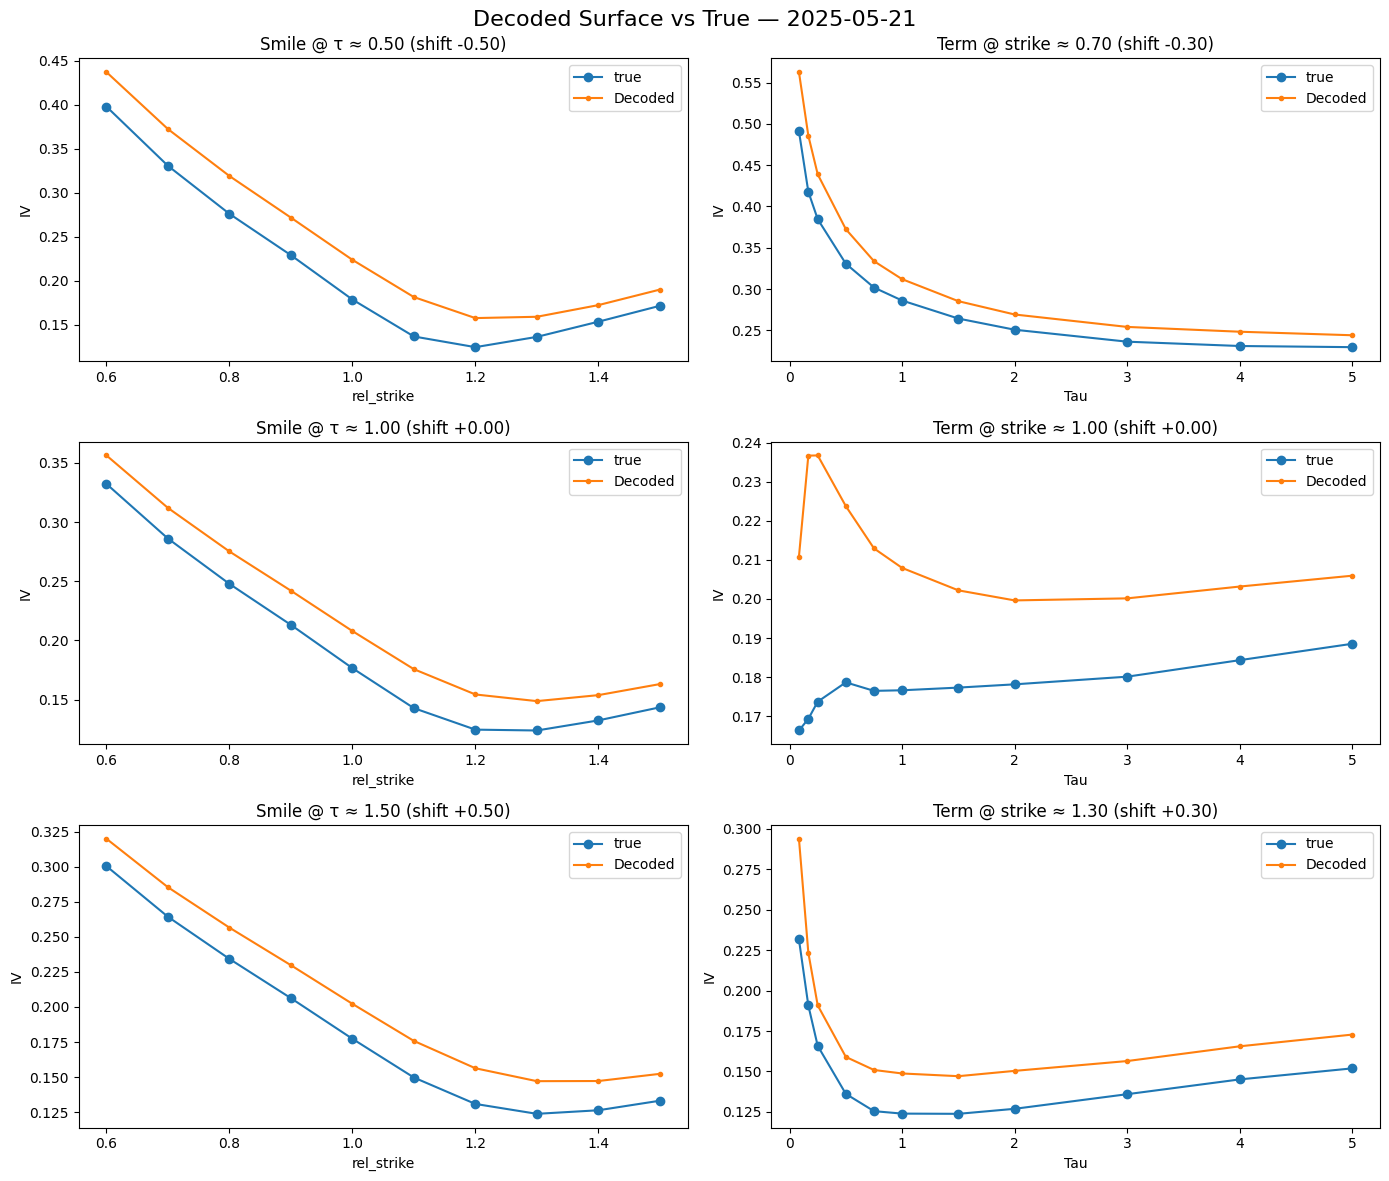

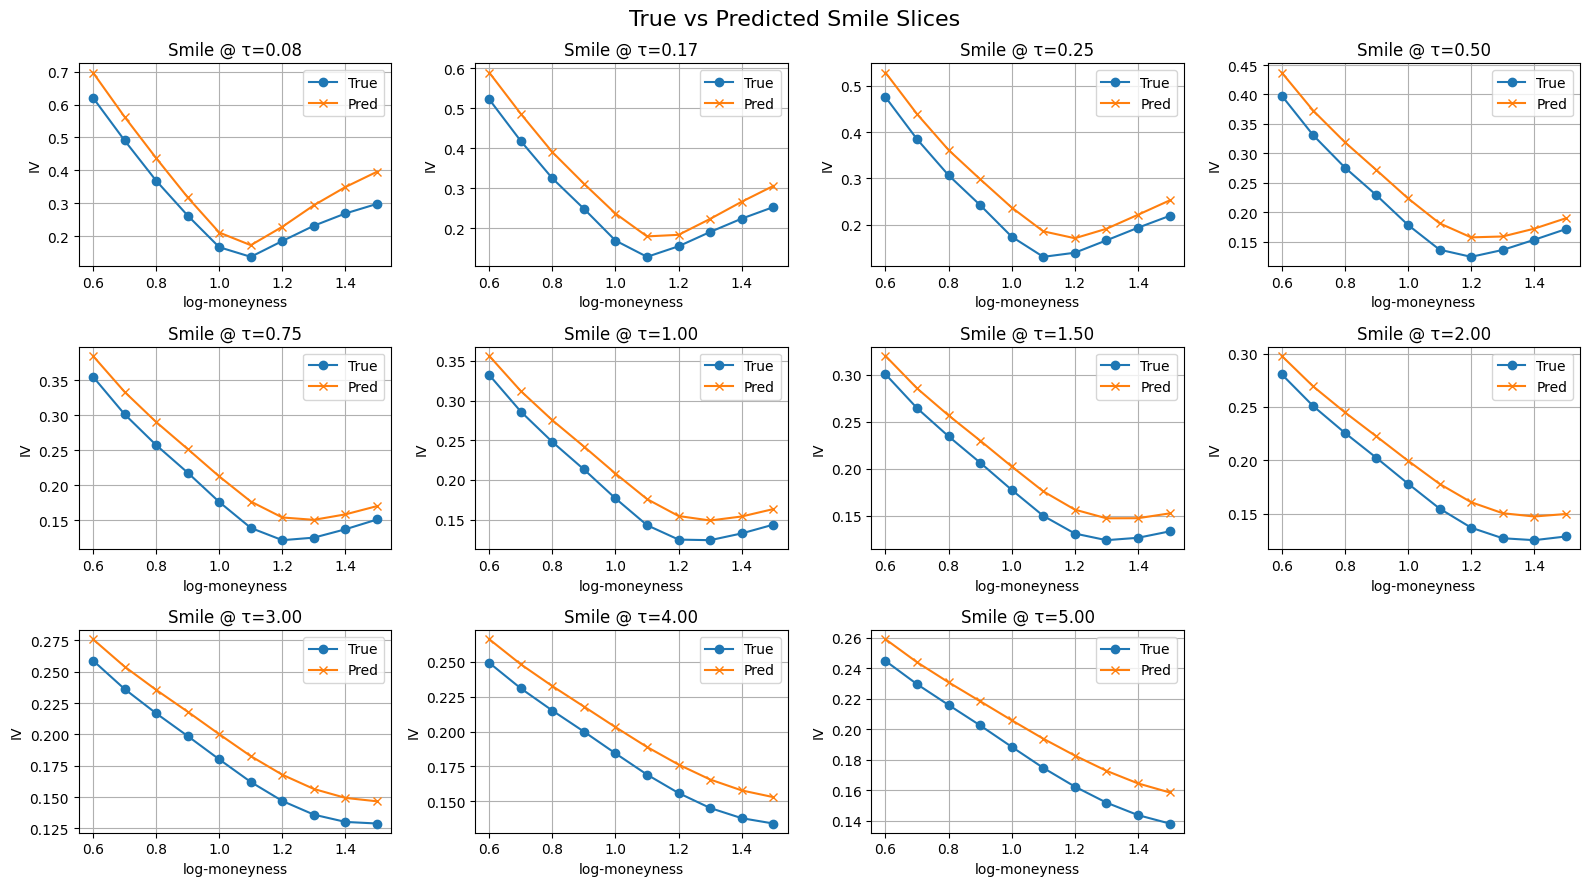

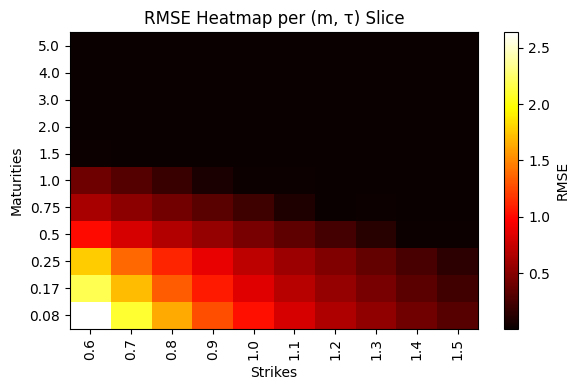

{'rmse_overall': 0.33165252,
 'rmse_by_maturity': array([1.3541164 , 1.1143248 , 0.9157723 , 0.53065366, 0.31801835,
        0.17224537, 0.01303721, 0.01078014, 0.00877496, 0.00768628,
        0.00669488], dtype=float32),
 'rmse_by_strike': array([1.2219307 , 0.9636205 , 0.7589455 , 0.6017895 , 0.48053858,
        0.3818558 , 0.30527973, 0.23814833, 0.1781341 , 0.12368406],
       dtype=float32)}

In [40]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# get ae baseline surfaces
Y_ae_baseline = decoder.predict(Z_eval)[:, :M*K]  # (N, M*K)

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate mlp residual corrections
Y_residual_corrections = np.stack([
  rl_model.predict_surface(z, f, m_flat, tau_flat)  # pass features f
  for z, f in zip(Z_eval, F_eval)
])

# combine: final = ae baseline + mlp corrections
Y_hat = Y_ae_baseline.reshape(-1, M, K) + Y_residual_corrections.reshape(-1, M, K)

print(f"y_ae_baseline shape: {Y_ae_baseline.shape}")
print(f"y_residual_corrections shape: {Y_residual_corrections.shape}")
print(f"y_hat (final) shape: {Y_hat.shape}")

# evaluate combined model
evaluate_decoder_output_v2(
   Y_pred=Y_hat,                          # fw-pca + mlp corrections
   Y_true=Y_full,                         # ground truth
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=rl_model,                      # mlp decoder for penalty calc
   title="AE + MLP Residual Corrections (With Features)"
)